##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 自编码器简介

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/generative/autoencoder">     <img src="https://tensorflow.google.cn/images/tf_logo_32px.png">     在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/autoencoder.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/autoencoder.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/generative/autoencoder.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

本教程通过以下三个示例介绍自编码器：基础知识、图像降噪和异常检测。

自编码器是一种特殊类型的神经网络，经过训练后可将其输入复制到其输出。例如，给定一个手写数字的图像，自编码器首先将图像编码为低维的潜在表示，然后将该潜在表示解码回图像。自编码器学习压缩数据，同时最大程度地减少重构误差。

要详细了解自编码器，请考虑阅读 Ian Goodfellow、Yoshua Bengio 和 Aaron Courville 撰写的[《深度学习》](https://www.deeplearningbook.org/)一书的第 14 章。

## 导入 TensorFlow 和其他库

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2023-11-07 19:41:16.708459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 19:41:16.708505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 19:41:16.710018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 加载数据集

首先，您将使用 Fashion MNIST 数据集训练基本自编码器。此数据集中的每个图像均为 28x28 像素。 

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

 8192/29515 [=======>......................] - ETA: 0s

29515/29515 [==============================] - 0s 0us/step


    8192/26421880 [..............................] - ETA: 0s

 4202496/26421880 [===>..........................] - ETA: 0s

16523264/26421880 [=================>............] - ETA: 0s

24494080/26421880 [==========================>...] - ETA: 0s

26421880/26421880 [==============================] - 0s 0us/step


5148/5148 [==============================] - 0s 0us/step


   8192/4422102 [..............................] - ETA: 0s

4422102/4422102 [==============================] - 0s 0us/step


(60000, 28, 28)
(10000, 28, 28)


## 第一个示例：基本自编码器

![Basic autoencoder results](images/intro_autoencoder_result.png)

定义一个具有两个密集层的自编码器：一个将图像压缩为 64 维隐向量的 `encoder`，以及一个从隐空间重构原始图像的 `decoder`。

要定义模型，请使用 [Keras Model Subclassing API](https://tensorflow.google.cn/guide/keras/custom_layers_and_models)。


In [4]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

使用 `x_train` 作为输入和目标来训练模型。`encoder` 会学习将数据集从 784 个维度压缩到隐空间，而 `decoder` 将学习重构原始图像。

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


I0000 00:00:1699386084.268834  448569 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1/1875 [..............................] - ETA: 47:46 - loss: 0.1674

  25/1875 [..............................] - ETA: 3s - loss: 0.1296   

  50/1875 [..............................] - ETA: 3s - loss: 0.1034

  75/1875 [>.............................] - ETA: 3s - loss: 0.0885

  99/1875 [>.............................] - ETA: 3s - loss: 0.0793

 124/1875 [>.............................] - ETA: 3s - loss: 0.0729

 150/1875 [=>............................] - ETA: 3s - loss: 0.0677

 176/1875 [=>............................] - ETA: 3s - loss: 0.0637

 202/1875 [==>...........................] - ETA: 3s - loss: 0.0601

 227/1875 [==>...........................] - ETA: 3s - loss: 0.0576

 253/1875 [===>..........................] - ETA: 3s - loss: 0.0553

 280/1875 [===>..........................] - ETA: 3s - loss: 0.0530

 306/1875 [===>..........................] - ETA: 3s - loss: 0.0512

 332/1875 [====>.........................] - ETA: 3s - loss: 0.0495

 357/1875 [====>.........................] - ETA: 3s - loss: 0.0481

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0467

 409/1875 [=====>........................] - ETA: 2s - loss: 0.0455

 434/1875 [=====>........................] - ETA: 2s - loss: 0.0445

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0436

 485/1875 [======>.......................] - ETA: 2s - loss: 0.0425

 510/1875 [=======>......................] - ETA: 2s - loss: 0.0417

 535/1875 [=======>......................] - ETA: 2s - loss: 0.0409

 560/1875 [=======>......................] - ETA: 2s - loss: 0.0402

 585/1875 [========>.....................] - ETA: 2s - loss: 0.0394

 610/1875 [========>.....................] - ETA: 2s - loss: 0.0388

 636/1875 [=========>....................] - ETA: 2s - loss: 0.0381

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0375

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0369

 713/1875 [==========>...................] - ETA: 2s - loss: 0.0363

 738/1875 [==========>...................] - ETA: 2s - loss: 0.0358

 764/1875 [===========>..................] - ETA: 2s - loss: 0.0353

 790/1875 [===========>..................] - ETA: 2s - loss: 0.0349

 815/1875 [============>.................] - ETA: 2s - loss: 0.0344

 840/1875 [============>.................] - ETA: 2s - loss: 0.0340

 865/1875 [============>.................] - ETA: 2s - loss: 0.0336

 891/1875 [=============>................] - ETA: 1s - loss: 0.0331

 916/1875 [=============>................] - ETA: 1s - loss: 0.0327

 942/1875 [==============>...............] - ETA: 1s - loss: 0.0324

 967/1875 [==============>...............] - ETA: 1s - loss: 0.0320

 992/1875 [==============>...............] - ETA: 1s - loss: 0.0316

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0313

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0309

1069/1875 [================>.............] - ETA: 1s - loss: 0.0306

1096/1875 [================>.............] - ETA: 1s - loss: 0.0303

1122/1875 [================>.............] - ETA: 1s - loss: 0.0300

1148/1875 [=================>............] - ETA: 1s - loss: 0.0297

1174/1875 [=================>............] - ETA: 1s - loss: 0.0294

1199/1875 [==================>...........] - ETA: 1s - loss: 0.0291

1224/1875 [==================>...........] - ETA: 1s - loss: 0.0288

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0286

1277/1875 [===================>..........] - ETA: 1s - loss: 0.0283

1302/1875 [===================>..........] - ETA: 1s - loss: 0.0280

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0278

1354/1875 [====================>.........] - ETA: 1s - loss: 0.0275

1380/1875 [=====================>........] - ETA: 0s - loss: 0.0273

1406/1875 [=====================>........] - ETA: 0s - loss: 0.0271

1432/1875 [=====================>........] - ETA: 0s - loss: 0.0268

1457/1875 [======================>.......] - ETA: 0s - loss: 0.0266

1484/1875 [======================>.......] - ETA: 0s - loss: 0.0264

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0262

1535/1875 [=======================>......] - ETA: 0s - loss: 0.0260

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0258

1587/1875 [========================>.....] - ETA: 0s - loss: 0.0256

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0254

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0253

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0251

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0249

1714/1875 [==========================>...] - ETA: 0s - loss: 0.0248

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0246

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0244

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0243

1816/1875 [============================>.] - ETA: 0s - loss: 0.0241

1841/1875 [============================>.] - ETA: 0s - loss: 0.0240

1866/1875 [============================>.] - ETA: 0s - loss: 0.0239

1875/1875 [==============================] - 6s 2ms/step - loss: 0.0238 - val_loss: 0.0132


Epoch 2/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0141

  26/1875 [..............................] - ETA: 3s - loss: 0.0132

  52/1875 [..............................] - ETA: 3s - loss: 0.0134

  78/1875 [>.............................] - ETA: 3s - loss: 0.0134

 103/1875 [>.............................] - ETA: 3s - loss: 0.0133

 129/1875 [=>............................] - ETA: 3s - loss: 0.0133

 155/1875 [=>............................] - ETA: 3s - loss: 0.0133

 181/1875 [=>............................] - ETA: 3s - loss: 0.0131

 208/1875 [==>...........................] - ETA: 3s - loss: 0.0131

 234/1875 [==>...........................] - ETA: 3s - loss: 0.0131

 260/1875 [===>..........................] - ETA: 3s - loss: 0.0131

 285/1875 [===>..........................] - ETA: 3s - loss: 0.0130

 311/1875 [===>..........................] - ETA: 3s - loss: 0.0130

 336/1875 [====>.........................] - ETA: 3s - loss: 0.0129

 362/1875 [====>.........................] - ETA: 2s - loss: 0.0129

 388/1875 [=====>........................] - ETA: 2s - loss: 0.0129

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0128

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0128

 467/1875 [======>.......................] - ETA: 2s - loss: 0.0127

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0127

 519/1875 [=======>......................] - ETA: 2s - loss: 0.0127

 545/1875 [=======>......................] - ETA: 2s - loss: 0.0127

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0126

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0126

 623/1875 [========>.....................] - ETA: 2s - loss: 0.0126

 649/1875 [=========>....................] - ETA: 2s - loss: 0.0125

 675/1875 [=========>....................] - ETA: 2s - loss: 0.0125

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0125

 729/1875 [==========>...................] - ETA: 2s - loss: 0.0125

 756/1875 [===========>..................] - ETA: 2s - loss: 0.0124

 782/1875 [===========>..................] - ETA: 2s - loss: 0.0124

 809/1875 [===========>..................] - ETA: 2s - loss: 0.0124

 835/1875 [============>.................] - ETA: 2s - loss: 0.0124

 861/1875 [============>.................] - ETA: 1s - loss: 0.0123

 887/1875 [=============>................] - ETA: 1s - loss: 0.0123

 912/1875 [=============>................] - ETA: 1s - loss: 0.0123

 937/1875 [=============>................] - ETA: 1s - loss: 0.0123

 963/1875 [==============>...............] - ETA: 1s - loss: 0.0123

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0122

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0122

1040/1875 [===============>..............] - ETA: 1s - loss: 0.0122

1066/1875 [================>.............] - ETA: 1s - loss: 0.0122

1093/1875 [================>.............] - ETA: 1s - loss: 0.0122

1119/1875 [================>.............] - ETA: 1s - loss: 0.0121

1145/1875 [=================>............] - ETA: 1s - loss: 0.0121

1171/1875 [=================>............] - ETA: 1s - loss: 0.0121

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0121

1223/1875 [==================>...........] - ETA: 1s - loss: 0.0120

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0120

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0120

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0120

1326/1875 [====================>.........] - ETA: 1s - loss: 0.0120

1351/1875 [====================>.........] - ETA: 1s - loss: 0.0120

1376/1875 [=====================>........] - ETA: 0s - loss: 0.0120

1401/1875 [=====================>........] - ETA: 0s - loss: 0.0120

1426/1875 [=====================>........] - ETA: 0s - loss: 0.0119

1451/1875 [======================>.......] - ETA: 0s - loss: 0.0119

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0119

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0119

1526/1875 [=======================>......] - ETA: 0s - loss: 0.0119

1550/1875 [=======================>......] - ETA: 0s - loss: 0.0119

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0118

1600/1875 [========================>.....] - ETA: 0s - loss: 0.0118

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0118

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0118

1675/1875 [=========================>....] - ETA: 0s - loss: 0.0118

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0118

1726/1875 [==========================>...] - ETA: 0s - loss: 0.0118

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0117

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0117

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0117

1829/1875 [============================>.] - ETA: 0s - loss: 0.0117

1855/1875 [============================>.] - ETA: 0s - loss: 0.0117

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0117 - val_loss: 0.0108


Epoch 3/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0112

  27/1875 [..............................] - ETA: 3s - loss: 0.0110

  53/1875 [..............................] - ETA: 3s - loss: 0.0109

  80/1875 [>.............................] - ETA: 3s - loss: 0.0108

 107/1875 [>.............................] - ETA: 3s - loss: 0.0107

 133/1875 [=>............................] - ETA: 3s - loss: 0.0107

 160/1875 [=>............................] - ETA: 3s - loss: 0.0107

 186/1875 [=>............................] - ETA: 3s - loss: 0.0106

 213/1875 [==>...........................] - ETA: 3s - loss: 0.0106

 239/1875 [==>...........................] - ETA: 3s - loss: 0.0105

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0105

 292/1875 [===>..........................] - ETA: 3s - loss: 0.0105

 317/1875 [====>.........................] - ETA: 3s - loss: 0.0105

 342/1875 [====>.........................] - ETA: 2s - loss: 0.0105

 368/1875 [====>.........................] - ETA: 2s - loss: 0.0105

 395/1875 [=====>........................] - ETA: 2s - loss: 0.0105

 421/1875 [=====>........................] - ETA: 2s - loss: 0.0105

 449/1875 [======>.......................] - ETA: 2s - loss: 0.0105

 476/1875 [======>.......................] - ETA: 2s - loss: 0.0105

 503/1875 [=======>......................] - ETA: 2s - loss: 0.0104

 530/1875 [=======>......................] - ETA: 2s - loss: 0.0105

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0105

 583/1875 [========>.....................] - ETA: 2s - loss: 0.0105

 609/1875 [========>.....................] - ETA: 2s - loss: 0.0105

 635/1875 [=========>....................] - ETA: 2s - loss: 0.0105

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0104

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0104

 714/1875 [==========>...................] - ETA: 2s - loss: 0.0104

 740/1875 [==========>...................] - ETA: 2s - loss: 0.0104

 766/1875 [===========>..................] - ETA: 2s - loss: 0.0104

 792/1875 [===========>..................] - ETA: 2s - loss: 0.0104

 818/1875 [============>.................] - ETA: 2s - loss: 0.0104

 844/1875 [============>.................] - ETA: 1s - loss: 0.0104

 870/1875 [============>.................] - ETA: 1s - loss: 0.0104

 896/1875 [=============>................] - ETA: 1s - loss: 0.0104

 923/1875 [=============>................] - ETA: 1s - loss: 0.0104

 950/1875 [==============>...............] - ETA: 1s - loss: 0.0104

 977/1875 [==============>...............] - ETA: 1s - loss: 0.0104

1004/1875 [===============>..............] - ETA: 1s - loss: 0.0104

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0104

1056/1875 [===============>..............] - ETA: 1s - loss: 0.0104

1083/1875 [================>.............] - ETA: 1s - loss: 0.0103

1109/1875 [================>.............] - ETA: 1s - loss: 0.0103

1136/1875 [=================>............] - ETA: 1s - loss: 0.0103

1162/1875 [=================>............] - ETA: 1s - loss: 0.0103

1188/1875 [==================>...........] - ETA: 1s - loss: 0.0103

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0103

1238/1875 [==================>...........] - ETA: 1s - loss: 0.0103

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0103

1289/1875 [===================>..........] - ETA: 1s - loss: 0.0103

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0103

1340/1875 [====================>.........] - ETA: 1s - loss: 0.0103

1365/1875 [====================>.........] - ETA: 0s - loss: 0.0103

1390/1875 [=====================>........] - ETA: 0s - loss: 0.0103

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0102

1444/1875 [======================>.......] - ETA: 0s - loss: 0.0102

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0102

1494/1875 [======================>.......] - ETA: 0s - loss: 0.0102

1520/1875 [=======================>......] - ETA: 0s - loss: 0.0102

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0102

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0102

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0102

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0102

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0102

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0102

1699/1875 [==========================>...] - ETA: 0s - loss: 0.0102

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0102

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0102

1776/1875 [===========================>..] - ETA: 0s - loss: 0.0102

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0102

1828/1875 [============================>.] - ETA: 0s - loss: 0.0102

1855/1875 [============================>.] - ETA: 0s - loss: 0.0102

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0102 - val_loss: 0.0098


Epoch 4/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0094

  26/1875 [..............................] - ETA: 3s - loss: 0.0096

  51/1875 [..............................] - ETA: 3s - loss: 0.0096

  76/1875 [>.............................] - ETA: 3s - loss: 0.0098

 102/1875 [>.............................] - ETA: 3s - loss: 0.0098

 127/1875 [=>............................] - ETA: 3s - loss: 0.0098

 153/1875 [=>............................] - ETA: 3s - loss: 0.0098

 179/1875 [=>............................] - ETA: 3s - loss: 0.0098

 204/1875 [==>...........................] - ETA: 3s - loss: 0.0097

 229/1875 [==>...........................] - ETA: 3s - loss: 0.0097

 255/1875 [===>..........................] - ETA: 3s - loss: 0.0097

 280/1875 [===>..........................] - ETA: 3s - loss: 0.0097

 305/1875 [===>..........................] - ETA: 3s - loss: 0.0096

 330/1875 [====>.........................] - ETA: 3s - loss: 0.0096

 354/1875 [====>.........................] - ETA: 3s - loss: 0.0096

 378/1875 [=====>........................] - ETA: 3s - loss: 0.0097

 402/1875 [=====>........................] - ETA: 3s - loss: 0.0097

 426/1875 [=====>........................] - ETA: 2s - loss: 0.0097

 450/1875 [======>.......................] - ETA: 2s - loss: 0.0097

 474/1875 [======>.......................] - ETA: 2s - loss: 0.0096

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0097

 522/1875 [=======>......................] - ETA: 2s - loss: 0.0097

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0097

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0097

 595/1875 [========>.....................] - ETA: 2s - loss: 0.0097

 620/1875 [========>.....................] - ETA: 2s - loss: 0.0097

 645/1875 [=========>....................] - ETA: 2s - loss: 0.0097

 669/1875 [=========>....................] - ETA: 2s - loss: 0.0097

 693/1875 [==========>...................] - ETA: 2s - loss: 0.0097

 717/1875 [==========>...................] - ETA: 2s - loss: 0.0097

 742/1875 [==========>...................] - ETA: 2s - loss: 0.0097

 766/1875 [===========>..................] - ETA: 2s - loss: 0.0096

 790/1875 [===========>..................] - ETA: 2s - loss: 0.0096

 814/1875 [============>.................] - ETA: 2s - loss: 0.0096

 838/1875 [============>.................] - ETA: 2s - loss: 0.0096

 863/1875 [============>.................] - ETA: 2s - loss: 0.0096

 888/1875 [=============>................] - ETA: 2s - loss: 0.0096

 912/1875 [=============>................] - ETA: 2s - loss: 0.0096

 936/1875 [=============>................] - ETA: 1s - loss: 0.0096

 960/1875 [==============>...............] - ETA: 1s - loss: 0.0096

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0096

1008/1875 [===============>..............] - ETA: 1s - loss: 0.0096

1032/1875 [===============>..............] - ETA: 1s - loss: 0.0096

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0096

1078/1875 [================>.............] - ETA: 1s - loss: 0.0096

1102/1875 [================>.............] - ETA: 1s - loss: 0.0096

1126/1875 [=================>............] - ETA: 1s - loss: 0.0096

1150/1875 [=================>............] - ETA: 1s - loss: 0.0096

1173/1875 [=================>............] - ETA: 1s - loss: 0.0096

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0096

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0096

1245/1875 [==================>...........] - ETA: 1s - loss: 0.0096

1269/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1317/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1341/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1389/1875 [=====================>........] - ETA: 1s - loss: 0.0096

1414/1875 [=====================>........] - ETA: 0s - loss: 0.0096

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0096

1462/1875 [======================>.......] - ETA: 0s - loss: 0.0096

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0096

1508/1875 [=======================>......] - ETA: 0s - loss: 0.0096

1532/1875 [=======================>......] - ETA: 0s - loss: 0.0096

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0096

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0096

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0096

1628/1875 [=========================>....] - ETA: 0s - loss: 0.0096

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0096

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0096

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0096

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0095

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0095

1820/1875 [============================>.] - ETA: 0s - loss: 0.0095

1845/1875 [============================>.] - ETA: 0s - loss: 0.0095

1869/1875 [============================>.] - ETA: 0s - loss: 0.0095

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0094


Epoch 5/10


   1/1875 [..............................] - ETA: 6s - loss: 0.0101

  27/1875 [..............................] - ETA: 3s - loss: 0.0092

  53/1875 [..............................] - ETA: 3s - loss: 0.0092

  79/1875 [>.............................] - ETA: 3s - loss: 0.0093

 105/1875 [>.............................] - ETA: 3s - loss: 0.0093

 131/1875 [=>............................] - ETA: 3s - loss: 0.0093

 157/1875 [=>............................] - ETA: 3s - loss: 0.0092

 183/1875 [=>............................] - ETA: 3s - loss: 0.0092

 209/1875 [==>...........................] - ETA: 3s - loss: 0.0092

 235/1875 [==>...........................] - ETA: 3s - loss: 0.0092

 262/1875 [===>..........................] - ETA: 3s - loss: 0.0091

 289/1875 [===>..........................] - ETA: 3s - loss: 0.0092

 317/1875 [====>.........................] - ETA: 3s - loss: 0.0092

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0091

 373/1875 [====>.........................] - ETA: 2s - loss: 0.0092

 400/1875 [=====>........................] - ETA: 2s - loss: 0.0092

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0092

 452/1875 [======>.......................] - ETA: 2s - loss: 0.0092

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0092

 504/1875 [=======>......................] - ETA: 2s - loss: 0.0092

 531/1875 [=======>......................] - ETA: 2s - loss: 0.0092

 558/1875 [=======>......................] - ETA: 2s - loss: 0.0092

 585/1875 [========>.....................] - ETA: 2s - loss: 0.0092

 612/1875 [========>.....................] - ETA: 2s - loss: 0.0092

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0092

 667/1875 [=========>....................] - ETA: 2s - loss: 0.0092

 694/1875 [==========>...................] - ETA: 2s - loss: 0.0092

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0093

 747/1875 [==========>...................] - ETA: 2s - loss: 0.0093

 773/1875 [===========>..................] - ETA: 2s - loss: 0.0093

 799/1875 [===========>..................] - ETA: 2s - loss: 0.0093

 826/1875 [============>.................] - ETA: 2s - loss: 0.0093

 852/1875 [============>.................] - ETA: 1s - loss: 0.0093

 879/1875 [=============>................] - ETA: 1s - loss: 0.0092

 906/1875 [=============>................] - ETA: 1s - loss: 0.0092

 933/1875 [=============>................] - ETA: 1s - loss: 0.0092

 960/1875 [==============>...............] - ETA: 1s - loss: 0.0092

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0092

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0092

1039/1875 [===============>..............] - ETA: 1s - loss: 0.0092

1065/1875 [================>.............] - ETA: 1s - loss: 0.0092

1092/1875 [================>.............] - ETA: 1s - loss: 0.0092

1119/1875 [================>.............] - ETA: 1s - loss: 0.0092

1146/1875 [=================>............] - ETA: 1s - loss: 0.0092

1173/1875 [=================>............] - ETA: 1s - loss: 0.0092

1201/1875 [==================>...........] - ETA: 1s - loss: 0.0092

1228/1875 [==================>...........] - ETA: 1s - loss: 0.0092

1255/1875 [===================>..........] - ETA: 1s - loss: 0.0092

1282/1875 [===================>..........] - ETA: 1s - loss: 0.0092

1310/1875 [===================>..........] - ETA: 1s - loss: 0.0092

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0092

1365/1875 [====================>.........] - ETA: 0s - loss: 0.0092

1392/1875 [=====================>........] - ETA: 0s - loss: 0.0092

1419/1875 [=====================>........] - ETA: 0s - loss: 0.0092

1446/1875 [======================>.......] - ETA: 0s - loss: 0.0092

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0092

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0092

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0092

1554/1875 [=======================>......] - ETA: 0s - loss: 0.0092

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0092

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0092

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0092

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0092

1689/1875 [==========================>...] - ETA: 0s - loss: 0.0092

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0092

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0092

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0092

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0092

1824/1875 [============================>.] - ETA: 0s - loss: 0.0092

1851/1875 [============================>.] - ETA: 0s - loss: 0.0092

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092


Epoch 6/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0096

  28/1875 [..............................] - ETA: 3s - loss: 0.0092

  55/1875 [..............................] - ETA: 3s - loss: 0.0091

  81/1875 [>.............................] - ETA: 3s - loss: 0.0091

 107/1875 [>.............................] - ETA: 3s - loss: 0.0090

 134/1875 [=>............................] - ETA: 3s - loss: 0.0090

 161/1875 [=>............................] - ETA: 3s - loss: 0.0090

 188/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 215/1875 [==>...........................] - ETA: 3s - loss: 0.0091

 242/1875 [==>...........................] - ETA: 3s - loss: 0.0091

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0091

 295/1875 [===>..........................] - ETA: 3s - loss: 0.0091

 322/1875 [====>.........................] - ETA: 2s - loss: 0.0091

 348/1875 [====>.........................] - ETA: 2s - loss: 0.0091

 375/1875 [=====>........................] - ETA: 2s - loss: 0.0091

 401/1875 [=====>........................] - ETA: 2s - loss: 0.0091

 428/1875 [=====>........................] - ETA: 2s - loss: 0.0091

 455/1875 [======>.......................] - ETA: 2s - loss: 0.0091

 481/1875 [======>.......................] - ETA: 2s - loss: 0.0091

 507/1875 [=======>......................] - ETA: 2s - loss: 0.0091

 533/1875 [=======>......................] - ETA: 2s - loss: 0.0091

 560/1875 [=======>......................] - ETA: 2s - loss: 0.0091

 586/1875 [========>.....................] - ETA: 2s - loss: 0.0091

 613/1875 [========>.....................] - ETA: 2s - loss: 0.0091

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0091

 665/1875 [=========>....................] - ETA: 2s - loss: 0.0091

 692/1875 [==========>...................] - ETA: 2s - loss: 0.0091

 718/1875 [==========>...................] - ETA: 2s - loss: 0.0091

 746/1875 [==========>...................] - ETA: 2s - loss: 0.0091

 774/1875 [===========>..................] - ETA: 2s - loss: 0.0091

 800/1875 [===========>..................] - ETA: 2s - loss: 0.0091

 827/1875 [============>.................] - ETA: 2s - loss: 0.0091

 854/1875 [============>.................] - ETA: 1s - loss: 0.0091

 880/1875 [=============>................] - ETA: 1s - loss: 0.0091

 906/1875 [=============>................] - ETA: 1s - loss: 0.0091

 932/1875 [=============>................] - ETA: 1s - loss: 0.0091

 958/1875 [==============>...............] - ETA: 1s - loss: 0.0091

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0091

1011/1875 [===============>..............] - ETA: 1s - loss: 0.0091

1038/1875 [===============>..............] - ETA: 1s - loss: 0.0091

1065/1875 [================>.............] - ETA: 1s - loss: 0.0091

1091/1875 [================>.............] - ETA: 1s - loss: 0.0091

1117/1875 [================>.............] - ETA: 1s - loss: 0.0091

1142/1875 [=================>............] - ETA: 1s - loss: 0.0091

1168/1875 [=================>............] - ETA: 1s - loss: 0.0091

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0091

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0091

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0091

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0091

1299/1875 [===================>..........] - ETA: 1s - loss: 0.0091

1325/1875 [====================>.........] - ETA: 1s - loss: 0.0091

1351/1875 [====================>.........] - ETA: 1s - loss: 0.0091

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0091

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0091

1428/1875 [=====================>........] - ETA: 0s - loss: 0.0091

1454/1875 [======================>.......] - ETA: 0s - loss: 0.0091

1480/1875 [======================>.......] - ETA: 0s - loss: 0.0091

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0091

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0091

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0091

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0091

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0091

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0091

1659/1875 [=========================>....] - ETA: 0s - loss: 0.0091

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0091

1712/1875 [==========================>...] - ETA: 0s - loss: 0.0091

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0091

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0091

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0091

1817/1875 [============================>.] - ETA: 0s - loss: 0.0091

1844/1875 [============================>.] - ETA: 0s - loss: 0.0091

1871/1875 [============================>.] - ETA: 0s - loss: 0.0091

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0091


Epoch 7/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0080

  25/1875 [..............................] - ETA: 3s - loss: 0.0091

  50/1875 [..............................] - ETA: 3s - loss: 0.0091

  75/1875 [>.............................] - ETA: 3s - loss: 0.0091

 100/1875 [>.............................] - ETA: 3s - loss: 0.0090

 125/1875 [=>............................] - ETA: 3s - loss: 0.0089

 150/1875 [=>............................] - ETA: 3s - loss: 0.0090

 175/1875 [=>............................] - ETA: 3s - loss: 0.0090

 200/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 225/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 250/1875 [===>..........................] - ETA: 3s - loss: 0.0090

 275/1875 [===>..........................] - ETA: 3s - loss: 0.0090

 300/1875 [===>..........................] - ETA: 3s - loss: 0.0090

 325/1875 [====>.........................] - ETA: 3s - loss: 0.0090

 350/1875 [====>.........................] - ETA: 3s - loss: 0.0090

 375/1875 [=====>........................] - ETA: 3s - loss: 0.0090

 401/1875 [=====>........................] - ETA: 3s - loss: 0.0090

 426/1875 [=====>........................] - ETA: 2s - loss: 0.0090

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0090

 476/1875 [======>.......................] - ETA: 2s - loss: 0.0090

 501/1875 [=======>......................] - ETA: 2s - loss: 0.0090

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0090

 552/1875 [=======>......................] - ETA: 2s - loss: 0.0090

 577/1875 [========>.....................] - ETA: 2s - loss: 0.0090

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0090

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 653/1875 [=========>....................] - ETA: 2s - loss: 0.0090

 678/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 703/1875 [==========>...................] - ETA: 2s - loss: 0.0090

 727/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 751/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 776/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 800/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 824/1875 [============>.................] - ETA: 2s - loss: 0.0089

 849/1875 [============>.................] - ETA: 2s - loss: 0.0089

 875/1875 [=============>................] - ETA: 2s - loss: 0.0090

 900/1875 [=============>................] - ETA: 1s - loss: 0.0090

 927/1875 [=============>................] - ETA: 1s - loss: 0.0089

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0090

 979/1875 [==============>...............] - ETA: 1s - loss: 0.0090

1005/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1031/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1057/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1083/1875 [================>.............] - ETA: 1s - loss: 0.0090

1109/1875 [================>.............] - ETA: 1s - loss: 0.0090

1135/1875 [=================>............] - ETA: 1s - loss: 0.0090

1161/1875 [=================>............] - ETA: 1s - loss: 0.0090

1187/1875 [=================>............] - ETA: 1s - loss: 0.0090

1214/1875 [==================>...........] - ETA: 1s - loss: 0.0090

1240/1875 [==================>...........] - ETA: 1s - loss: 0.0090

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0090

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0090

1319/1875 [====================>.........] - ETA: 1s - loss: 0.0090

1345/1875 [====================>.........] - ETA: 1s - loss: 0.0090

1372/1875 [====================>.........] - ETA: 1s - loss: 0.0090

1398/1875 [=====================>........] - ETA: 0s - loss: 0.0090

1424/1875 [=====================>........] - ETA: 0s - loss: 0.0090

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0090

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0090

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1553/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1657/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1834/1875 [============================>.] - ETA: 0s - loss: 0.0090

1859/1875 [============================>.] - ETA: 0s - loss: 0.0090

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090


Epoch 8/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0082

  27/1875 [..............................] - ETA: 3s - loss: 0.0087

  53/1875 [..............................] - ETA: 3s - loss: 0.0089

  79/1875 [>.............................] - ETA: 3s - loss: 0.0089

 105/1875 [>.............................] - ETA: 3s - loss: 0.0089

 130/1875 [=>............................] - ETA: 3s - loss: 0.0089

 156/1875 [=>............................] - ETA: 3s - loss: 0.0088

 182/1875 [=>............................] - ETA: 3s - loss: 0.0088

 208/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 235/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 262/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 287/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 314/1875 [====>.........................] - ETA: 3s - loss: 0.0089

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 393/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 419/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 523/1875 [=======>......................] - ETA: 2s - loss: 0.0089

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0089

 574/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 600/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 652/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 678/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 704/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 730/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 756/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 782/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 809/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 836/1875 [============>.................] - ETA: 2s - loss: 0.0089

 863/1875 [============>.................] - ETA: 1s - loss: 0.0089

 890/1875 [=============>................] - ETA: 1s - loss: 0.0089

 916/1875 [=============>................] - ETA: 1s - loss: 0.0089

 942/1875 [==============>...............] - ETA: 1s - loss: 0.0089

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0089

 995/1875 [==============>...............] - ETA: 1s - loss: 0.0088

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1048/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1075/1875 [================>.............] - ETA: 1s - loss: 0.0089

1102/1875 [================>.............] - ETA: 1s - loss: 0.0089

1129/1875 [=================>............] - ETA: 1s - loss: 0.0089

1156/1875 [=================>............] - ETA: 1s - loss: 0.0089

1183/1875 [=================>............] - ETA: 1s - loss: 0.0089

1210/1875 [==================>...........] - ETA: 1s - loss: 0.0089

1237/1875 [==================>...........] - ETA: 1s - loss: 0.0089

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1290/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0089

1341/1875 [====================>.........] - ETA: 1s - loss: 0.0089

1368/1875 [====================>.........] - ETA: 0s - loss: 0.0089

1394/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1420/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1446/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1472/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1525/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1815/1875 [============================>.] - ETA: 0s - loss: 0.0089

1841/1875 [============================>.] - ETA: 0s - loss: 0.0089

1868/1875 [============================>.] - ETA: 0s - loss: 0.0089

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0090


Epoch 9/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0086

  27/1875 [..............................] - ETA: 3s - loss: 0.0089

  52/1875 [..............................] - ETA: 3s - loss: 0.0089

  78/1875 [>.............................] - ETA: 3s - loss: 0.0088

 103/1875 [>.............................] - ETA: 3s - loss: 0.0089

 129/1875 [=>............................] - ETA: 3s - loss: 0.0089

 154/1875 [=>............................] - ETA: 3s - loss: 0.0090

 180/1875 [=>............................] - ETA: 3s - loss: 0.0089

 206/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 232/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 258/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 285/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 311/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 337/1875 [====>.........................] - ETA: 3s - loss: 0.0089

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 390/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 416/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 442/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 518/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 544/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 570/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 595/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 621/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 675/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 727/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 752/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 778/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 804/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 830/1875 [============>.................] - ETA: 2s - loss: 0.0088

 856/1875 [============>.................] - ETA: 2s - loss: 0.0088

 882/1875 [=============>................] - ETA: 1s - loss: 0.0088

 908/1875 [=============>................] - ETA: 1s - loss: 0.0088

 935/1875 [=============>................] - ETA: 1s - loss: 0.0088

 961/1875 [==============>...............] - ETA: 1s - loss: 0.0088

 987/1875 [==============>...............] - ETA: 1s - loss: 0.0088

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1039/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1065/1875 [================>.............] - ETA: 1s - loss: 0.0088

1091/1875 [================>.............] - ETA: 1s - loss: 0.0088

1116/1875 [================>.............] - ETA: 1s - loss: 0.0088

1142/1875 [=================>............] - ETA: 1s - loss: 0.0088

1167/1875 [=================>............] - ETA: 1s - loss: 0.0088

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1245/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1271/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1297/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1350/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1404/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1430/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1457/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1484/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1537/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1563/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1819/1875 [============================>.] - ETA: 0s - loss: 0.0088

1846/1875 [============================>.] - ETA: 0s - loss: 0.0088

1873/1875 [============================>.] - ETA: 0s - loss: 0.0088

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089


Epoch 10/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0101

  28/1875 [..............................] - ETA: 3s - loss: 0.0089

  54/1875 [..............................] - ETA: 3s - loss: 0.0088

  79/1875 [>.............................] - ETA: 3s - loss: 0.0089

 105/1875 [>.............................] - ETA: 3s - loss: 0.0088

 131/1875 [=>............................] - ETA: 3s - loss: 0.0088

 158/1875 [=>............................] - ETA: 3s - loss: 0.0088

 185/1875 [=>............................] - ETA: 3s - loss: 0.0087

 212/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 239/1875 [==>...........................] - ETA: 3s - loss: 0.0087

 265/1875 [===>..........................] - ETA: 3s - loss: 0.0087

 291/1875 [===>..........................] - ETA: 3s - loss: 0.0087

 318/1875 [====>.........................] - ETA: 2s - loss: 0.0087

 344/1875 [====>.........................] - ETA: 2s - loss: 0.0087

 371/1875 [====>.........................] - ETA: 2s - loss: 0.0087

 398/1875 [=====>........................] - ETA: 2s - loss: 0.0087

 424/1875 [=====>........................] - ETA: 2s - loss: 0.0087

 450/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 476/1875 [======>.......................] - ETA: 2s - loss: 0.0087

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 529/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0087

 583/1875 [========>.....................] - ETA: 2s - loss: 0.0087

 609/1875 [========>.....................] - ETA: 2s - loss: 0.0087

 635/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 661/1875 [=========>....................] - ETA: 2s - loss: 0.0087

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0087

 714/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 740/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 766/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 792/1875 [===========>..................] - ETA: 2s - loss: 0.0087

 818/1875 [============>.................] - ETA: 2s - loss: 0.0088

 844/1875 [============>.................] - ETA: 1s - loss: 0.0088

 870/1875 [============>.................] - ETA: 1s - loss: 0.0088

 896/1875 [=============>................] - ETA: 1s - loss: 0.0088

 922/1875 [=============>................] - ETA: 1s - loss: 0.0088

 948/1875 [==============>...............] - ETA: 1s - loss: 0.0088

 975/1875 [==============>...............] - ETA: 1s - loss: 0.0088

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1082/1875 [================>.............] - ETA: 1s - loss: 0.0088

1109/1875 [================>.............] - ETA: 1s - loss: 0.0088

1136/1875 [=================>............] - ETA: 1s - loss: 0.0088

1163/1875 [=================>............] - ETA: 1s - loss: 0.0088

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1218/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1245/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1299/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1326/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1352/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1378/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1432/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1458/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1537/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1563/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1750/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1829/1875 [============================>.] - ETA: 0s - loss: 0.0088

1856/1875 [============================>.] - ETA: 0s - loss: 0.0088

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089


现在，模型已经训练完成，我们通过对测试集中的图像进行编码和解码来测试该模型。

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

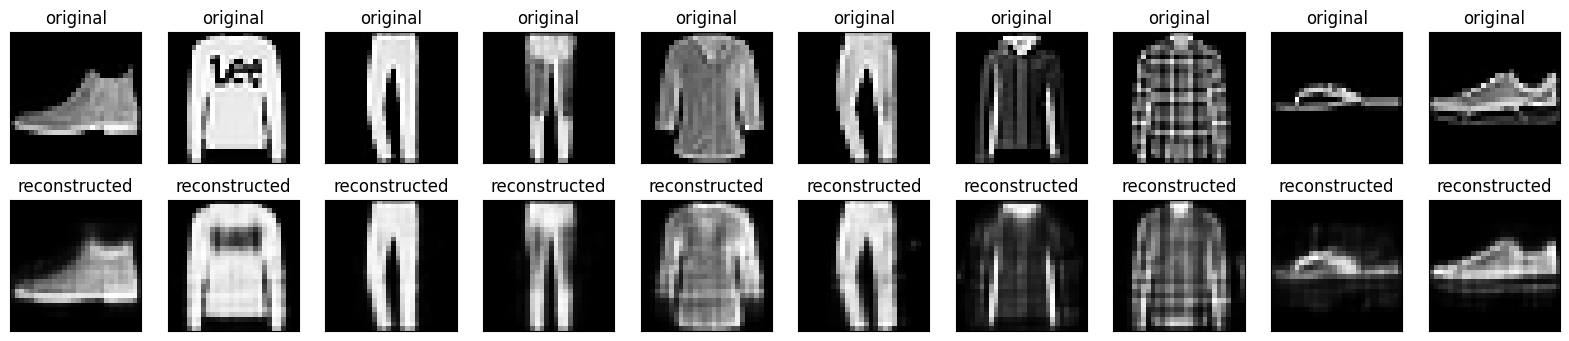

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## 第二个示例：图像降噪

![Image denoising results](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/images/image_denoise_fmnist_results.png?raw=true)

经过训练后，自编码器还可以去除图像中的噪点。在以下部分中，您将通过对每个图像应用随机噪声来创建有噪版本的 Fashion MNIST 数据集。随后，您将使用有噪图像作为输入并以原始图像作为目标来训练自编码器。

我们重新导入数据集以忽略之前所做的修改：

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


向图像添加随机噪声：

In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

绘制有噪图像：


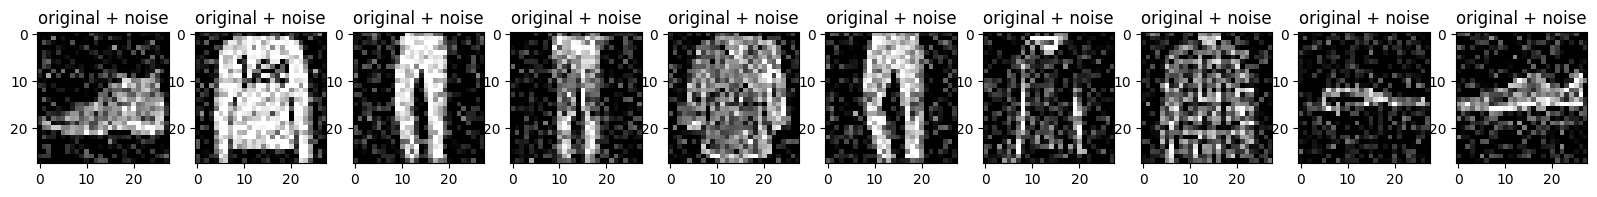

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### 定义卷积自编码器

在此示例中，您将使用 `encoder` 中的 [Conv2D](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Conv2D) 层和 `decoder` 中的 [Conv2DTranspose](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Conv2DTranspose) 层来训练卷积自编码器。

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10


   1/1875 [..............................] - ETA: 1:24:33 - loss: 0.1709

  15/1875 [..............................] - ETA: 6s - loss: 0.1679     

  30/1875 [..............................] - ETA: 6s - loss: 0.1605

  45/1875 [..............................] - ETA: 6s - loss: 0.1489

  60/1875 [..............................] - ETA: 6s - loss: 0.1337

  76/1875 [>.............................] - ETA: 6s - loss: 0.1177

  91/1875 [>.............................] - ETA: 6s - loss: 0.1043

 106/1875 [>.............................] - ETA: 6s - loss: 0.0937

 122/1875 [>.............................] - ETA: 5s - loss: 0.0850

 137/1875 [=>............................] - ETA: 5s - loss: 0.0784

 153/1875 [=>............................] - ETA: 5s - loss: 0.0726

 168/1875 [=>............................] - ETA: 5s - loss: 0.0681

 184/1875 [=>............................] - ETA: 5s - loss: 0.0639

 200/1875 [==>...........................] - ETA: 5s - loss: 0.0603

 216/1875 [==>...........................] - ETA: 5s - loss: 0.0572

 232/1875 [==>...........................] - ETA: 5s - loss: 0.0545

 248/1875 [==>...........................] - ETA: 5s - loss: 0.0520

 263/1875 [===>..........................] - ETA: 5s - loss: 0.0500

 279/1875 [===>..........................] - ETA: 5s - loss: 0.0480

 295/1875 [===>..........................] - ETA: 5s - loss: 0.0462

 311/1875 [===>..........................] - ETA: 5s - loss: 0.0446

 326/1875 [====>.........................] - ETA: 5s - loss: 0.0432

 342/1875 [====>.........................] - ETA: 5s - loss: 0.0418

 358/1875 [====>.........................] - ETA: 5s - loss: 0.0406

 374/1875 [====>.........................] - ETA: 5s - loss: 0.0394

 389/1875 [=====>........................] - ETA: 4s - loss: 0.0384

 405/1875 [=====>........................] - ETA: 4s - loss: 0.0374

 420/1875 [=====>........................] - ETA: 4s - loss: 0.0365

 436/1875 [=====>........................] - ETA: 4s - loss: 0.0357

 452/1875 [======>.......................] - ETA: 4s - loss: 0.0349

 468/1875 [======>.......................] - ETA: 4s - loss: 0.0341

 484/1875 [======>.......................] - ETA: 4s - loss: 0.0334

 500/1875 [=======>......................] - ETA: 4s - loss: 0.0327

 516/1875 [=======>......................] - ETA: 4s - loss: 0.0321

 532/1875 [=======>......................] - ETA: 4s - loss: 0.0315

 548/1875 [=======>......................] - ETA: 4s - loss: 0.0309

 563/1875 [========>.....................] - ETA: 4s - loss: 0.0304

 579/1875 [========>.....................] - ETA: 4s - loss: 0.0299

 595/1875 [========>.....................] - ETA: 4s - loss: 0.0294

 611/1875 [========>.....................] - ETA: 4s - loss: 0.0290

 626/1875 [=========>....................] - ETA: 4s - loss: 0.0286

 642/1875 [=========>....................] - ETA: 4s - loss: 0.0281

 658/1875 [=========>....................] - ETA: 4s - loss: 0.0277

 674/1875 [=========>....................] - ETA: 3s - loss: 0.0273

 690/1875 [==========>...................] - ETA: 3s - loss: 0.0270

 706/1875 [==========>...................] - ETA: 3s - loss: 0.0266

 722/1875 [==========>...................] - ETA: 3s - loss: 0.0263

 739/1875 [==========>...................] - ETA: 3s - loss: 0.0259

 756/1875 [===========>..................] - ETA: 3s - loss: 0.0256

 772/1875 [===========>..................] - ETA: 3s - loss: 0.0253

 788/1875 [===========>..................] - ETA: 3s - loss: 0.0250

 804/1875 [===========>..................] - ETA: 3s - loss: 0.0247

 820/1875 [============>.................] - ETA: 3s - loss: 0.0244

 836/1875 [============>.................] - ETA: 3s - loss: 0.0241

 852/1875 [============>.................] - ETA: 3s - loss: 0.0239

 868/1875 [============>.................] - ETA: 3s - loss: 0.0237

 884/1875 [=============>................] - ETA: 3s - loss: 0.0234

 900/1875 [=============>................] - ETA: 3s - loss: 0.0232

 916/1875 [=============>................] - ETA: 3s - loss: 0.0230

 932/1875 [=============>................] - ETA: 3s - loss: 0.0227

 948/1875 [==============>...............] - ETA: 3s - loss: 0.0225

 964/1875 [==============>...............] - ETA: 2s - loss: 0.0223

 980/1875 [==============>...............] - ETA: 2s - loss: 0.0221

 996/1875 [==============>...............] - ETA: 2s - loss: 0.0220

1012/1875 [===============>..............] - ETA: 2s - loss: 0.0218

1028/1875 [===============>..............] - ETA: 2s - loss: 0.0216

1044/1875 [===============>..............] - ETA: 2s - loss: 0.0214

1060/1875 [===============>..............] - ETA: 2s - loss: 0.0213

1076/1875 [================>.............] - ETA: 2s - loss: 0.0211

1092/1875 [================>.............] - ETA: 2s - loss: 0.0209

1108/1875 [================>.............] - ETA: 2s - loss: 0.0208

1124/1875 [================>.............] - ETA: 2s - loss: 0.0206

1140/1875 [=================>............] - ETA: 2s - loss: 0.0205

1156/1875 [=================>............] - ETA: 2s - loss: 0.0203

1172/1875 [=================>............] - ETA: 2s - loss: 0.0202

1188/1875 [==================>...........] - ETA: 2s - loss: 0.0201

1204/1875 [==================>...........] - ETA: 2s - loss: 0.0199

1220/1875 [==================>...........] - ETA: 2s - loss: 0.0198

1236/1875 [==================>...........] - ETA: 2s - loss: 0.0197

1252/1875 [===================>..........] - ETA: 2s - loss: 0.0195

1268/1875 [===================>..........] - ETA: 1s - loss: 0.0194

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0193

1300/1875 [===================>..........] - ETA: 1s - loss: 0.0192

1316/1875 [====================>.........] - ETA: 1s - loss: 0.0191

1332/1875 [====================>.........] - ETA: 1s - loss: 0.0189

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0188

1364/1875 [====================>.........] - ETA: 1s - loss: 0.0187

1381/1875 [=====================>........] - ETA: 1s - loss: 0.0186

1397/1875 [=====================>........] - ETA: 1s - loss: 0.0185

1413/1875 [=====================>........] - ETA: 1s - loss: 0.0184

1429/1875 [=====================>........] - ETA: 1s - loss: 0.0183

1445/1875 [======================>.......] - ETA: 1s - loss: 0.0182

1461/1875 [======================>.......] - ETA: 1s - loss: 0.0181

1477/1875 [======================>.......] - ETA: 1s - loss: 0.0180

1493/1875 [======================>.......] - ETA: 1s - loss: 0.0179

1509/1875 [=======================>......] - ETA: 1s - loss: 0.0179

1525/1875 [=======================>......] - ETA: 1s - loss: 0.0178

1541/1875 [=======================>......] - ETA: 1s - loss: 0.0177

1558/1875 [=======================>......] - ETA: 1s - loss: 0.0176

1574/1875 [========================>.....] - ETA: 0s - loss: 0.0175

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0174

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0174

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0173

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0172

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0171

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0171

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0170

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0169

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0168

1734/1875 [==========================>...] - ETA: 0s - loss: 0.0168

1750/1875 [===========================>..] - ETA: 0s - loss: 0.0167

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0166

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0166

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0165

1814/1875 [============================>.] - ETA: 0s - loss: 0.0164

1831/1875 [============================>.] - ETA: 0s - loss: 0.0164

1847/1875 [============================>.] - ETA: 0s - loss: 0.0163

1862/1875 [============================>.] - ETA: 0s - loss: 0.0163

1875/1875 [==============================] - 10s 4ms/step - loss: 0.0162 - val_loss: 0.0093


Epoch 2/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0090

  17/1875 [..............................] - ETA: 5s - loss: 0.0098

  33/1875 [..............................] - ETA: 5s - loss: 0.0095

  49/1875 [..............................] - ETA: 5s - loss: 0.0094

  64/1875 [>.............................] - ETA: 5s - loss: 0.0094

  80/1875 [>.............................] - ETA: 5s - loss: 0.0093

  96/1875 [>.............................] - ETA: 5s - loss: 0.0092

 112/1875 [>.............................] - ETA: 5s - loss: 0.0092

 129/1875 [=>............................] - ETA: 5s - loss: 0.0092

 145/1875 [=>............................] - ETA: 5s - loss: 0.0092

 160/1875 [=>............................] - ETA: 5s - loss: 0.0092

 176/1875 [=>............................] - ETA: 5s - loss: 0.0092

 192/1875 [==>...........................] - ETA: 5s - loss: 0.0092

 207/1875 [==>...........................] - ETA: 5s - loss: 0.0092

 223/1875 [==>...........................] - ETA: 5s - loss: 0.0092

 239/1875 [==>...........................] - ETA: 5s - loss: 0.0092

 255/1875 [===>..........................] - ETA: 5s - loss: 0.0092

 271/1875 [===>..........................] - ETA: 5s - loss: 0.0091

 287/1875 [===>..........................] - ETA: 5s - loss: 0.0091

 304/1875 [===>..........................] - ETA: 5s - loss: 0.0091

 321/1875 [====>.........................] - ETA: 4s - loss: 0.0091

 338/1875 [====>.........................] - ETA: 4s - loss: 0.0091

 355/1875 [====>.........................] - ETA: 4s - loss: 0.0091

 371/1875 [====>.........................] - ETA: 4s - loss: 0.0091

 387/1875 [=====>........................] - ETA: 4s - loss: 0.0091

 403/1875 [=====>........................] - ETA: 4s - loss: 0.0091

 419/1875 [=====>........................] - ETA: 4s - loss: 0.0091

 435/1875 [=====>........................] - ETA: 4s - loss: 0.0091

 452/1875 [======>.......................] - ETA: 4s - loss: 0.0091

 469/1875 [======>.......................] - ETA: 4s - loss: 0.0091

 485/1875 [======>.......................] - ETA: 4s - loss: 0.0091

 501/1875 [=======>......................] - ETA: 4s - loss: 0.0091

 517/1875 [=======>......................] - ETA: 4s - loss: 0.0091

 533/1875 [=======>......................] - ETA: 4s - loss: 0.0090

 548/1875 [=======>......................] - ETA: 4s - loss: 0.0090

 564/1875 [========>.....................] - ETA: 4s - loss: 0.0090

 580/1875 [========>.....................] - ETA: 4s - loss: 0.0090

 596/1875 [========>.....................] - ETA: 4s - loss: 0.0090

 612/1875 [========>.....................] - ETA: 4s - loss: 0.0090

 628/1875 [=========>....................] - ETA: 4s - loss: 0.0090

 644/1875 [=========>....................] - ETA: 3s - loss: 0.0090

 660/1875 [=========>....................] - ETA: 3s - loss: 0.0090

 676/1875 [=========>....................] - ETA: 3s - loss: 0.0090

 692/1875 [==========>...................] - ETA: 3s - loss: 0.0090

 708/1875 [==========>...................] - ETA: 3s - loss: 0.0090

 724/1875 [==========>...................] - ETA: 3s - loss: 0.0090

 740/1875 [==========>...................] - ETA: 3s - loss: 0.0090

 756/1875 [===========>..................] - ETA: 3s - loss: 0.0090

 772/1875 [===========>..................] - ETA: 3s - loss: 0.0090

 788/1875 [===========>..................] - ETA: 3s - loss: 0.0090

 804/1875 [===========>..................] - ETA: 3s - loss: 0.0090

 820/1875 [============>.................] - ETA: 3s - loss: 0.0090

 836/1875 [============>.................] - ETA: 3s - loss: 0.0090

 852/1875 [============>.................] - ETA: 3s - loss: 0.0089

 868/1875 [============>.................] - ETA: 3s - loss: 0.0089

 884/1875 [=============>................] - ETA: 3s - loss: 0.0089

 900/1875 [=============>................] - ETA: 3s - loss: 0.0089

 916/1875 [=============>................] - ETA: 3s - loss: 0.0089

 932/1875 [=============>................] - ETA: 3s - loss: 0.0089

 948/1875 [==============>...............] - ETA: 2s - loss: 0.0089

 964/1875 [==============>...............] - ETA: 2s - loss: 0.0089

 980/1875 [==============>...............] - ETA: 2s - loss: 0.0089

 996/1875 [==============>...............] - ETA: 2s - loss: 0.0089

1012/1875 [===============>..............] - ETA: 2s - loss: 0.0089

1028/1875 [===============>..............] - ETA: 2s - loss: 0.0089

1044/1875 [===============>..............] - ETA: 2s - loss: 0.0089

1060/1875 [===============>..............] - ETA: 2s - loss: 0.0089

1076/1875 [================>.............] - ETA: 2s - loss: 0.0089

1092/1875 [================>.............] - ETA: 2s - loss: 0.0089

1109/1875 [================>.............] - ETA: 2s - loss: 0.0089

1125/1875 [=================>............] - ETA: 2s - loss: 0.0089

1141/1875 [=================>............] - ETA: 2s - loss: 0.0088

1157/1875 [=================>............] - ETA: 2s - loss: 0.0088

1172/1875 [=================>............] - ETA: 2s - loss: 0.0088

1188/1875 [==================>...........] - ETA: 2s - loss: 0.0088

1204/1875 [==================>...........] - ETA: 2s - loss: 0.0088

1220/1875 [==================>...........] - ETA: 2s - loss: 0.0088

1236/1875 [==================>...........] - ETA: 2s - loss: 0.0088

1253/1875 [===================>..........] - ETA: 2s - loss: 0.0088

1269/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1285/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1317/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1333/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1349/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0088

1380/1875 [=====================>........] - ETA: 1s - loss: 0.0088

1395/1875 [=====================>........] - ETA: 1s - loss: 0.0088

1411/1875 [=====================>........] - ETA: 1s - loss: 0.0088

1427/1875 [=====================>........] - ETA: 1s - loss: 0.0087

1443/1875 [======================>.......] - ETA: 1s - loss: 0.0087

1459/1875 [======================>.......] - ETA: 1s - loss: 0.0087

1475/1875 [======================>.......] - ETA: 1s - loss: 0.0087

1491/1875 [======================>.......] - ETA: 1s - loss: 0.0087

1507/1875 [=======================>......] - ETA: 1s - loss: 0.0087

1523/1875 [=======================>......] - ETA: 1s - loss: 0.0087

1539/1875 [=======================>......] - ETA: 1s - loss: 0.0087

1555/1875 [=======================>......] - ETA: 1s - loss: 0.0087

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0087

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0087

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0087

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0087

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0087

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0087

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0087

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0086

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0086

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0086

1776/1875 [===========================>..] - ETA: 0s - loss: 0.0086

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0086

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0086

1822/1875 [============================>.] - ETA: 0s - loss: 0.0086

1838/1875 [============================>.] - ETA: 0s - loss: 0.0086

1854/1875 [============================>.] - ETA: 0s - loss: 0.0086

1870/1875 [============================>.] - ETA: 0s - loss: 0.0086

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0086 - val_loss: 0.0081


Epoch 3/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0078

  16/1875 [..............................] - ETA: 6s - loss: 0.0081

  32/1875 [..............................] - ETA: 6s - loss: 0.0081

  48/1875 [..............................] - ETA: 5s - loss: 0.0081

  64/1875 [>.............................] - ETA: 5s - loss: 0.0081

  80/1875 [>.............................] - ETA: 5s - loss: 0.0081

  95/1875 [>.............................] - ETA: 5s - loss: 0.0081

 110/1875 [>.............................] - ETA: 5s - loss: 0.0081

 126/1875 [=>............................] - ETA: 5s - loss: 0.0081

 142/1875 [=>............................] - ETA: 5s - loss: 0.0080

 158/1875 [=>............................] - ETA: 5s - loss: 0.0080

 174/1875 [=>............................] - ETA: 5s - loss: 0.0080

 190/1875 [==>...........................] - ETA: 5s - loss: 0.0080

 206/1875 [==>...........................] - ETA: 5s - loss: 0.0080

 222/1875 [==>...........................] - ETA: 5s - loss: 0.0080

 238/1875 [==>...........................] - ETA: 5s - loss: 0.0080

 254/1875 [===>..........................] - ETA: 5s - loss: 0.0080

 270/1875 [===>..........................] - ETA: 5s - loss: 0.0080

 286/1875 [===>..........................] - ETA: 5s - loss: 0.0080

 301/1875 [===>..........................] - ETA: 5s - loss: 0.0080

 316/1875 [====>.........................] - ETA: 5s - loss: 0.0080

 331/1875 [====>.........................] - ETA: 5s - loss: 0.0080

 346/1875 [====>.........................] - ETA: 5s - loss: 0.0080

 362/1875 [====>.........................] - ETA: 4s - loss: 0.0080

 378/1875 [=====>........................] - ETA: 4s - loss: 0.0080

 393/1875 [=====>........................] - ETA: 4s - loss: 0.0080

 409/1875 [=====>........................] - ETA: 4s - loss: 0.0080

 425/1875 [=====>........................] - ETA: 4s - loss: 0.0080

 441/1875 [======>.......................] - ETA: 4s - loss: 0.0080

 457/1875 [======>.......................] - ETA: 4s - loss: 0.0080

 473/1875 [======>.......................] - ETA: 4s - loss: 0.0080

 488/1875 [======>.......................] - ETA: 4s - loss: 0.0080

 504/1875 [=======>......................] - ETA: 4s - loss: 0.0080

 520/1875 [=======>......................] - ETA: 4s - loss: 0.0079

 536/1875 [=======>......................] - ETA: 4s - loss: 0.0079

 552/1875 [=======>......................] - ETA: 4s - loss: 0.0079

 568/1875 [========>.....................] - ETA: 4s - loss: 0.0079

 584/1875 [========>.....................] - ETA: 4s - loss: 0.0079

 600/1875 [========>.....................] - ETA: 4s - loss: 0.0079

 616/1875 [========>.....................] - ETA: 4s - loss: 0.0079

 631/1875 [=========>....................] - ETA: 4s - loss: 0.0079

 646/1875 [=========>....................] - ETA: 4s - loss: 0.0079

 662/1875 [=========>....................] - ETA: 3s - loss: 0.0079

 678/1875 [=========>....................] - ETA: 3s - loss: 0.0079

 694/1875 [==========>...................] - ETA: 3s - loss: 0.0079

 709/1875 [==========>...................] - ETA: 3s - loss: 0.0079

 725/1875 [==========>...................] - ETA: 3s - loss: 0.0079

 741/1875 [==========>...................] - ETA: 3s - loss: 0.0079

 757/1875 [===========>..................] - ETA: 3s - loss: 0.0079

 773/1875 [===========>..................] - ETA: 3s - loss: 0.0079

 789/1875 [===========>..................] - ETA: 3s - loss: 0.0078

 805/1875 [===========>..................] - ETA: 3s - loss: 0.0078

 821/1875 [============>.................] - ETA: 3s - loss: 0.0078

 837/1875 [============>.................] - ETA: 3s - loss: 0.0078

 853/1875 [============>.................] - ETA: 3s - loss: 0.0078

 869/1875 [============>.................] - ETA: 3s - loss: 0.0078

 885/1875 [=============>................] - ETA: 3s - loss: 0.0078

 901/1875 [=============>................] - ETA: 3s - loss: 0.0078

 916/1875 [=============>................] - ETA: 3s - loss: 0.0078

 931/1875 [=============>................] - ETA: 3s - loss: 0.0078

 946/1875 [==============>...............] - ETA: 3s - loss: 0.0078

 962/1875 [==============>...............] - ETA: 2s - loss: 0.0078

 978/1875 [==============>...............] - ETA: 2s - loss: 0.0078

 994/1875 [==============>...............] - ETA: 2s - loss: 0.0078

1010/1875 [===============>..............] - ETA: 2s - loss: 0.0078

1026/1875 [===============>..............] - ETA: 2s - loss: 0.0078

1042/1875 [===============>..............] - ETA: 2s - loss: 0.0078

1057/1875 [===============>..............] - ETA: 2s - loss: 0.0078

1073/1875 [================>.............] - ETA: 2s - loss: 0.0078

1089/1875 [================>.............] - ETA: 2s - loss: 0.0078

1105/1875 [================>.............] - ETA: 2s - loss: 0.0078

1120/1875 [================>.............] - ETA: 2s - loss: 0.0078

1136/1875 [=================>............] - ETA: 2s - loss: 0.0078

1152/1875 [=================>............] - ETA: 2s - loss: 0.0078

1168/1875 [=================>............] - ETA: 2s - loss: 0.0078

1183/1875 [=================>............] - ETA: 2s - loss: 0.0078

1199/1875 [==================>...........] - ETA: 2s - loss: 0.0078

1215/1875 [==================>...........] - ETA: 2s - loss: 0.0078

1231/1875 [==================>...........] - ETA: 2s - loss: 0.0077

1247/1875 [==================>...........] - ETA: 2s - loss: 0.0077

1263/1875 [===================>..........] - ETA: 2s - loss: 0.0077

1279/1875 [===================>..........] - ETA: 1s - loss: 0.0077

1295/1875 [===================>..........] - ETA: 1s - loss: 0.0077

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0077

1326/1875 [====================>.........] - ETA: 1s - loss: 0.0077

1342/1875 [====================>.........] - ETA: 1s - loss: 0.0077

1358/1875 [====================>.........] - ETA: 1s - loss: 0.0077

1374/1875 [====================>.........] - ETA: 1s - loss: 0.0077

1390/1875 [=====================>........] - ETA: 1s - loss: 0.0077

1406/1875 [=====================>........] - ETA: 1s - loss: 0.0077

1422/1875 [=====================>........] - ETA: 1s - loss: 0.0077

1438/1875 [======================>.......] - ETA: 1s - loss: 0.0077

1454/1875 [======================>.......] - ETA: 1s - loss: 0.0077

1470/1875 [======================>.......] - ETA: 1s - loss: 0.0077

1486/1875 [======================>.......] - ETA: 1s - loss: 0.0077

1502/1875 [=======================>......] - ETA: 1s - loss: 0.0077

1518/1875 [=======================>......] - ETA: 1s - loss: 0.0077

1534/1875 [=======================>......] - ETA: 1s - loss: 0.0077

1550/1875 [=======================>......] - ETA: 1s - loss: 0.0077

1566/1875 [========================>.....] - ETA: 1s - loss: 0.0077

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0077

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0077

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0077

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0077

1646/1875 [=========================>....] - ETA: 0s - loss: 0.0077

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0077

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0077

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0077

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0077

1726/1875 [==========================>...] - ETA: 0s - loss: 0.0077

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0077

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0077

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0077

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0077

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0076

1821/1875 [============================>.] - ETA: 0s - loss: 0.0076

1837/1875 [============================>.] - ETA: 0s - loss: 0.0076

1853/1875 [============================>.] - ETA: 0s - loss: 0.0076

1869/1875 [============================>.] - ETA: 0s - loss: 0.0076

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0076 - val_loss: 0.0073


Epoch 4/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0071

  17/1875 [..............................] - ETA: 6s - loss: 0.0075

  33/1875 [..............................] - ETA: 5s - loss: 0.0074

  49/1875 [..............................] - ETA: 5s - loss: 0.0074

  65/1875 [>.............................] - ETA: 5s - loss: 0.0074

  82/1875 [>.............................] - ETA: 5s - loss: 0.0073

  98/1875 [>.............................] - ETA: 5s - loss: 0.0074

 114/1875 [>.............................] - ETA: 5s - loss: 0.0073

 131/1875 [=>............................] - ETA: 5s - loss: 0.0073

 147/1875 [=>............................] - ETA: 5s - loss: 0.0073

 163/1875 [=>............................] - ETA: 5s - loss: 0.0073

 179/1875 [=>............................] - ETA: 5s - loss: 0.0073

 195/1875 [==>...........................] - ETA: 5s - loss: 0.0073

 211/1875 [==>...........................] - ETA: 5s - loss: 0.0073

 227/1875 [==>...........................] - ETA: 5s - loss: 0.0073

 243/1875 [==>...........................] - ETA: 5s - loss: 0.0073

 259/1875 [===>..........................] - ETA: 5s - loss: 0.0073

 275/1875 [===>..........................] - ETA: 5s - loss: 0.0073

 291/1875 [===>..........................] - ETA: 5s - loss: 0.0073

 307/1875 [===>..........................] - ETA: 4s - loss: 0.0073

 323/1875 [====>.........................] - ETA: 4s - loss: 0.0073

 339/1875 [====>.........................] - ETA: 4s - loss: 0.0073

 355/1875 [====>.........................] - ETA: 4s - loss: 0.0073

 371/1875 [====>.........................] - ETA: 4s - loss: 0.0073

 387/1875 [=====>........................] - ETA: 4s - loss: 0.0073

 403/1875 [=====>........................] - ETA: 4s - loss: 0.0073

 419/1875 [=====>........................] - ETA: 4s - loss: 0.0073

 435/1875 [=====>........................] - ETA: 4s - loss: 0.0073

 452/1875 [======>.......................] - ETA: 4s - loss: 0.0073

 468/1875 [======>.......................] - ETA: 4s - loss: 0.0073

 485/1875 [======>.......................] - ETA: 4s - loss: 0.0073

 501/1875 [=======>......................] - ETA: 4s - loss: 0.0073

 517/1875 [=======>......................] - ETA: 4s - loss: 0.0073

 533/1875 [=======>......................] - ETA: 4s - loss: 0.0073

 549/1875 [=======>......................] - ETA: 4s - loss: 0.0073

 565/1875 [========>.....................] - ETA: 4s - loss: 0.0073

 581/1875 [========>.....................] - ETA: 4s - loss: 0.0073

 597/1875 [========>.....................] - ETA: 4s - loss: 0.0073

 614/1875 [========>.....................] - ETA: 4s - loss: 0.0073

 631/1875 [=========>....................] - ETA: 3s - loss: 0.0073

 647/1875 [=========>....................] - ETA: 3s - loss: 0.0073

 663/1875 [=========>....................] - ETA: 3s - loss: 0.0073

 679/1875 [=========>....................] - ETA: 3s - loss: 0.0073

 695/1875 [==========>...................] - ETA: 3s - loss: 0.0073

 711/1875 [==========>...................] - ETA: 3s - loss: 0.0073

 727/1875 [==========>...................] - ETA: 3s - loss: 0.0073

 743/1875 [==========>...................] - ETA: 3s - loss: 0.0073

 759/1875 [===========>..................] - ETA: 3s - loss: 0.0072

 775/1875 [===========>..................] - ETA: 3s - loss: 0.0072

 791/1875 [===========>..................] - ETA: 3s - loss: 0.0073

 807/1875 [===========>..................] - ETA: 3s - loss: 0.0072

 823/1875 [============>.................] - ETA: 3s - loss: 0.0072

 839/1875 [============>.................] - ETA: 3s - loss: 0.0072

 855/1875 [============>.................] - ETA: 3s - loss: 0.0072

 871/1875 [============>.................] - ETA: 3s - loss: 0.0072

 887/1875 [=============>................] - ETA: 3s - loss: 0.0072

 903/1875 [=============>................] - ETA: 3s - loss: 0.0072

 919/1875 [=============>................] - ETA: 3s - loss: 0.0072

 935/1875 [=============>................] - ETA: 3s - loss: 0.0072

 951/1875 [==============>...............] - ETA: 2s - loss: 0.0072

 967/1875 [==============>...............] - ETA: 2s - loss: 0.0072

 983/1875 [==============>...............] - ETA: 2s - loss: 0.0072

 999/1875 [==============>...............] - ETA: 2s - loss: 0.0072

1015/1875 [===============>..............] - ETA: 2s - loss: 0.0072

1031/1875 [===============>..............] - ETA: 2s - loss: 0.0072

1048/1875 [===============>..............] - ETA: 2s - loss: 0.0072

1064/1875 [================>.............] - ETA: 2s - loss: 0.0072

1080/1875 [================>.............] - ETA: 2s - loss: 0.0072

1096/1875 [================>.............] - ETA: 2s - loss: 0.0072

1112/1875 [================>.............] - ETA: 2s - loss: 0.0072

1128/1875 [=================>............] - ETA: 2s - loss: 0.0072

1144/1875 [=================>............] - ETA: 2s - loss: 0.0072

1160/1875 [=================>............] - ETA: 2s - loss: 0.0072

1176/1875 [=================>............] - ETA: 2s - loss: 0.0072

1192/1875 [==================>...........] - ETA: 2s - loss: 0.0072

1208/1875 [==================>...........] - ETA: 2s - loss: 0.0072

1224/1875 [==================>...........] - ETA: 2s - loss: 0.0072

1240/1875 [==================>...........] - ETA: 2s - loss: 0.0072

1256/1875 [===================>..........] - ETA: 1s - loss: 0.0072

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0072

1288/1875 [===================>..........] - ETA: 1s - loss: 0.0072

1303/1875 [===================>..........] - ETA: 1s - loss: 0.0072

1319/1875 [====================>.........] - ETA: 1s - loss: 0.0072

1334/1875 [====================>.........] - ETA: 1s - loss: 0.0072

1349/1875 [====================>.........] - ETA: 1s - loss: 0.0072

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0072

1381/1875 [=====================>........] - ETA: 1s - loss: 0.0072

1397/1875 [=====================>........] - ETA: 1s - loss: 0.0072

1413/1875 [=====================>........] - ETA: 1s - loss: 0.0072

1429/1875 [=====================>........] - ETA: 1s - loss: 0.0072

1445/1875 [======================>.......] - ETA: 1s - loss: 0.0072

1461/1875 [======================>.......] - ETA: 1s - loss: 0.0072

1477/1875 [======================>.......] - ETA: 1s - loss: 0.0072

1493/1875 [======================>.......] - ETA: 1s - loss: 0.0072

1509/1875 [=======================>......] - ETA: 1s - loss: 0.0072

1525/1875 [=======================>......] - ETA: 1s - loss: 0.0072

1541/1875 [=======================>......] - ETA: 1s - loss: 0.0072

1556/1875 [=======================>......] - ETA: 1s - loss: 0.0072

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0072

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0072

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0072

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0072

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0072

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0072

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0072

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0072

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0072

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0072

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0072

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0072

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0072

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0072

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0072

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0072

1821/1875 [============================>.] - ETA: 0s - loss: 0.0072

1837/1875 [============================>.] - ETA: 0s - loss: 0.0072

1853/1875 [============================>.] - ETA: 0s - loss: 0.0072

1868/1875 [============================>.] - ETA: 0s - loss: 0.0072

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0072 - val_loss: 0.0071


Epoch 5/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0065

  17/1875 [..............................] - ETA: 6s - loss: 0.0073

  33/1875 [..............................] - ETA: 5s - loss: 0.0071

  49/1875 [..............................] - ETA: 5s - loss: 0.0071

  65/1875 [>.............................] - ETA: 5s - loss: 0.0071

  81/1875 [>.............................] - ETA: 5s - loss: 0.0072

  97/1875 [>.............................] - ETA: 5s - loss: 0.0071

 113/1875 [>.............................] - ETA: 5s - loss: 0.0071

 129/1875 [=>............................] - ETA: 5s - loss: 0.0071

 145/1875 [=>............................] - ETA: 5s - loss: 0.0071

 161/1875 [=>............................] - ETA: 5s - loss: 0.0071

 177/1875 [=>............................] - ETA: 5s - loss: 0.0071

 193/1875 [==>...........................] - ETA: 5s - loss: 0.0071

 209/1875 [==>...........................] - ETA: 5s - loss: 0.0070

 225/1875 [==>...........................] - ETA: 5s - loss: 0.0071

 241/1875 [==>...........................] - ETA: 5s - loss: 0.0071

 257/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 273/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 289/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 305/1875 [===>..........................] - ETA: 5s - loss: 0.0071

 321/1875 [====>.........................] - ETA: 5s - loss: 0.0071

 337/1875 [====>.........................] - ETA: 4s - loss: 0.0071

 353/1875 [====>.........................] - ETA: 4s - loss: 0.0071

 369/1875 [====>.........................] - ETA: 4s - loss: 0.0071

 385/1875 [=====>........................] - ETA: 4s - loss: 0.0071

 401/1875 [=====>........................] - ETA: 4s - loss: 0.0071

 417/1875 [=====>........................] - ETA: 4s - loss: 0.0071

 433/1875 [=====>........................] - ETA: 4s - loss: 0.0071

 449/1875 [======>.......................] - ETA: 4s - loss: 0.0071

 465/1875 [======>.......................] - ETA: 4s - loss: 0.0071

 480/1875 [======>.......................] - ETA: 4s - loss: 0.0071

 496/1875 [======>.......................] - ETA: 4s - loss: 0.0071

 512/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 528/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 544/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 560/1875 [=======>......................] - ETA: 4s - loss: 0.0071

 576/1875 [========>.....................] - ETA: 4s - loss: 0.0070

 592/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 608/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 624/1875 [========>.....................] - ETA: 4s - loss: 0.0071

 640/1875 [=========>....................] - ETA: 4s - loss: 0.0071

 656/1875 [=========>....................] - ETA: 3s - loss: 0.0071

 672/1875 [=========>....................] - ETA: 3s - loss: 0.0071

 688/1875 [==========>...................] - ETA: 3s - loss: 0.0071

 704/1875 [==========>...................] - ETA: 3s - loss: 0.0071

 720/1875 [==========>...................] - ETA: 3s - loss: 0.0071

 736/1875 [==========>...................] - ETA: 3s - loss: 0.0071

 751/1875 [===========>..................] - ETA: 3s - loss: 0.0070

 767/1875 [===========>..................] - ETA: 3s - loss: 0.0071

 783/1875 [===========>..................] - ETA: 3s - loss: 0.0070

 800/1875 [===========>..................] - ETA: 3s - loss: 0.0070

 817/1875 [============>.................] - ETA: 3s - loss: 0.0070

 833/1875 [============>.................] - ETA: 3s - loss: 0.0070

 849/1875 [============>.................] - ETA: 3s - loss: 0.0070

 865/1875 [============>.................] - ETA: 3s - loss: 0.0070

 880/1875 [=============>................] - ETA: 3s - loss: 0.0070

 895/1875 [=============>................] - ETA: 3s - loss: 0.0070

 910/1875 [=============>................] - ETA: 3s - loss: 0.0070

 926/1875 [=============>................] - ETA: 3s - loss: 0.0070

 942/1875 [==============>...............] - ETA: 3s - loss: 0.0070

 958/1875 [==============>...............] - ETA: 2s - loss: 0.0070

 974/1875 [==============>...............] - ETA: 2s - loss: 0.0070

 990/1875 [==============>...............] - ETA: 2s - loss: 0.0070

1006/1875 [===============>..............] - ETA: 2s - loss: 0.0070

1022/1875 [===============>..............] - ETA: 2s - loss: 0.0070

1039/1875 [===============>..............] - ETA: 2s - loss: 0.0070

1055/1875 [===============>..............] - ETA: 2s - loss: 0.0070

1071/1875 [================>.............] - ETA: 2s - loss: 0.0070

1087/1875 [================>.............] - ETA: 2s - loss: 0.0070

1103/1875 [================>.............] - ETA: 2s - loss: 0.0070

1119/1875 [================>.............] - ETA: 2s - loss: 0.0070

1135/1875 [=================>............] - ETA: 2s - loss: 0.0070

1151/1875 [=================>............] - ETA: 2s - loss: 0.0070

1167/1875 [=================>............] - ETA: 2s - loss: 0.0070

1184/1875 [=================>............] - ETA: 2s - loss: 0.0070

1200/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1216/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1232/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1248/1875 [==================>...........] - ETA: 2s - loss: 0.0070

1264/1875 [===================>..........] - ETA: 1s - loss: 0.0070

1280/1875 [===================>..........] - ETA: 1s - loss: 0.0070

1296/1875 [===================>..........] - ETA: 1s - loss: 0.0070

1312/1875 [===================>..........] - ETA: 1s - loss: 0.0070

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1344/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1360/1875 [====================>.........] - ETA: 1s - loss: 0.0070

1376/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1392/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1408/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1424/1875 [=====================>........] - ETA: 1s - loss: 0.0070

1440/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1456/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1472/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1488/1875 [======================>.......] - ETA: 1s - loss: 0.0070

1504/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1520/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1537/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1554/1875 [=======================>......] - ETA: 1s - loss: 0.0070

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0070

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0070

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0070

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1810/1875 [===========================>..] - ETA: 0s - loss: 0.0070

1826/1875 [============================>.] - ETA: 0s - loss: 0.0070

1842/1875 [============================>.] - ETA: 0s - loss: 0.0070

1858/1875 [============================>.] - ETA: 0s - loss: 0.0070

1874/1875 [============================>.] - ETA: 0s - loss: 0.0070

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0070 - val_loss: 0.0070


Epoch 6/10


   1/1875 [..............................] - ETA: 7s - loss: 0.0062

  17/1875 [..............................] - ETA: 6s - loss: 0.0069

  32/1875 [..............................] - ETA: 6s - loss: 0.0070

  48/1875 [..............................] - ETA: 6s - loss: 0.0070

  64/1875 [>.............................] - ETA: 5s - loss: 0.0070

  80/1875 [>.............................] - ETA: 5s - loss: 0.0070

  96/1875 [>.............................] - ETA: 5s - loss: 0.0070

 112/1875 [>.............................] - ETA: 5s - loss: 0.0070

 128/1875 [=>............................] - ETA: 5s - loss: 0.0070

 144/1875 [=>............................] - ETA: 5s - loss: 0.0070

 160/1875 [=>............................] - ETA: 5s - loss: 0.0070

 176/1875 [=>............................] - ETA: 5s - loss: 0.0069

 192/1875 [==>...........................] - ETA: 5s - loss: 0.0070

 208/1875 [==>...........................] - ETA: 5s - loss: 0.0069

 224/1875 [==>...........................] - ETA: 5s - loss: 0.0069

 240/1875 [==>...........................] - ETA: 5s - loss: 0.0069

 256/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 272/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 288/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 304/1875 [===>..........................] - ETA: 5s - loss: 0.0069

 320/1875 [====>.........................] - ETA: 5s - loss: 0.0069

 336/1875 [====>.........................] - ETA: 4s - loss: 0.0069

 352/1875 [====>.........................] - ETA: 4s - loss: 0.0069

 368/1875 [====>.........................] - ETA: 4s - loss: 0.0069

 384/1875 [=====>........................] - ETA: 4s - loss: 0.0069

 400/1875 [=====>........................] - ETA: 4s - loss: 0.0069

 416/1875 [=====>........................] - ETA: 4s - loss: 0.0069

 432/1875 [=====>........................] - ETA: 4s - loss: 0.0069

 448/1875 [======>.......................] - ETA: 4s - loss: 0.0069

 464/1875 [======>.......................] - ETA: 4s - loss: 0.0069

 480/1875 [======>.......................] - ETA: 4s - loss: 0.0069

 496/1875 [======>.......................] - ETA: 4s - loss: 0.0070

 512/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 528/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 544/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 560/1875 [=======>......................] - ETA: 4s - loss: 0.0069

 576/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 591/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 606/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 622/1875 [========>.....................] - ETA: 4s - loss: 0.0069

 638/1875 [=========>....................] - ETA: 4s - loss: 0.0069

 654/1875 [=========>....................] - ETA: 3s - loss: 0.0069

 669/1875 [=========>....................] - ETA: 3s - loss: 0.0069

 685/1875 [=========>....................] - ETA: 3s - loss: 0.0069

 700/1875 [==========>...................] - ETA: 3s - loss: 0.0069

 716/1875 [==========>...................] - ETA: 3s - loss: 0.0069

 732/1875 [==========>...................] - ETA: 3s - loss: 0.0069

 748/1875 [==========>...................] - ETA: 3s - loss: 0.0069

 764/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 780/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 796/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 812/1875 [===========>..................] - ETA: 3s - loss: 0.0069

 828/1875 [============>.................] - ETA: 3s - loss: 0.0069

 844/1875 [============>.................] - ETA: 3s - loss: 0.0069

 860/1875 [============>.................] - ETA: 3s - loss: 0.0069

 876/1875 [=============>................] - ETA: 3s - loss: 0.0069

 891/1875 [=============>................] - ETA: 3s - loss: 0.0069

 907/1875 [=============>................] - ETA: 3s - loss: 0.0069

 923/1875 [=============>................] - ETA: 3s - loss: 0.0069

 939/1875 [==============>...............] - ETA: 3s - loss: 0.0069

 955/1875 [==============>...............] - ETA: 2s - loss: 0.0069

 971/1875 [==============>...............] - ETA: 2s - loss: 0.0069

 986/1875 [==============>...............] - ETA: 2s - loss: 0.0069

1002/1875 [===============>..............] - ETA: 2s - loss: 0.0069

1018/1875 [===============>..............] - ETA: 2s - loss: 0.0069

1034/1875 [===============>..............] - ETA: 2s - loss: 0.0069

1050/1875 [===============>..............] - ETA: 2s - loss: 0.0069

1066/1875 [================>.............] - ETA: 2s - loss: 0.0069

1082/1875 [================>.............] - ETA: 2s - loss: 0.0069

1098/1875 [================>.............] - ETA: 2s - loss: 0.0069

1114/1875 [================>.............] - ETA: 2s - loss: 0.0069

1130/1875 [=================>............] - ETA: 2s - loss: 0.0069

1146/1875 [=================>............] - ETA: 2s - loss: 0.0069

1162/1875 [=================>............] - ETA: 2s - loss: 0.0069

1178/1875 [=================>............] - ETA: 2s - loss: 0.0069

1194/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1210/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1226/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1242/1875 [==================>...........] - ETA: 2s - loss: 0.0069

1257/1875 [===================>..........] - ETA: 2s - loss: 0.0069

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0069

1289/1875 [===================>..........] - ETA: 1s - loss: 0.0069

1305/1875 [===================>..........] - ETA: 1s - loss: 0.0069

1321/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1337/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1353/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1369/1875 [====================>.........] - ETA: 1s - loss: 0.0069

1385/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1401/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1417/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1433/1875 [=====================>........] - ETA: 1s - loss: 0.0069

1449/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1465/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1481/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1498/1875 [======================>.......] - ETA: 1s - loss: 0.0069

1514/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1530/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1546/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1562/1875 [=======================>......] - ETA: 1s - loss: 0.0069

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0069

1594/1875 [========================>.....] - ETA: 0s - loss: 0.0069

1610/1875 [========================>.....] - ETA: 0s - loss: 0.0069

1626/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0069

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1706/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0069

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0069

1819/1875 [============================>.] - ETA: 0s - loss: 0.0069

1836/1875 [============================>.] - ETA: 0s - loss: 0.0069

1853/1875 [============================>.] - ETA: 0s - loss: 0.0069

1869/1875 [============================>.] - ETA: 0s - loss: 0.0069

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0069 - val_loss: 0.0069


Epoch 7/10


   1/1875 [..............................] - ETA: 9s - loss: 0.0068

  17/1875 [..............................] - ETA: 6s - loss: 0.0069

  33/1875 [..............................] - ETA: 6s - loss: 0.0068

  49/1875 [..............................] - ETA: 6s - loss: 0.0069

  65/1875 [>.............................] - ETA: 5s - loss: 0.0068

  81/1875 [>.............................] - ETA: 5s - loss: 0.0069

  97/1875 [>.............................] - ETA: 5s - loss: 0.0069

 113/1875 [>.............................] - ETA: 5s - loss: 0.0068

 129/1875 [=>............................] - ETA: 5s - loss: 0.0068

 145/1875 [=>............................] - ETA: 5s - loss: 0.0069

 161/1875 [=>............................] - ETA: 5s - loss: 0.0069

 177/1875 [=>............................] - ETA: 5s - loss: 0.0069

 193/1875 [==>...........................] - ETA: 5s - loss: 0.0069

 209/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 225/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 241/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 257/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 272/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 288/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 304/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 320/1875 [====>.........................] - ETA: 5s - loss: 0.0068

 336/1875 [====>.........................] - ETA: 4s - loss: 0.0068

 352/1875 [====>.........................] - ETA: 4s - loss: 0.0068

 368/1875 [====>.........................] - ETA: 4s - loss: 0.0068

 384/1875 [=====>........................] - ETA: 4s - loss: 0.0068

 399/1875 [=====>........................] - ETA: 4s - loss: 0.0068

 415/1875 [=====>........................] - ETA: 4s - loss: 0.0068

 431/1875 [=====>........................] - ETA: 4s - loss: 0.0068

 447/1875 [======>.......................] - ETA: 4s - loss: 0.0068

 463/1875 [======>.......................] - ETA: 4s - loss: 0.0068

 479/1875 [======>.......................] - ETA: 4s - loss: 0.0068

 495/1875 [======>.......................] - ETA: 4s - loss: 0.0068

 511/1875 [=======>......................] - ETA: 4s - loss: 0.0068

 528/1875 [=======>......................] - ETA: 4s - loss: 0.0068

 544/1875 [=======>......................] - ETA: 4s - loss: 0.0068

 560/1875 [=======>......................] - ETA: 4s - loss: 0.0068

 576/1875 [========>.....................] - ETA: 4s - loss: 0.0068

 592/1875 [========>.....................] - ETA: 4s - loss: 0.0068

 608/1875 [========>.....................] - ETA: 4s - loss: 0.0068

 624/1875 [========>.....................] - ETA: 4s - loss: 0.0068

 640/1875 [=========>....................] - ETA: 3s - loss: 0.0068

 656/1875 [=========>....................] - ETA: 3s - loss: 0.0068

 672/1875 [=========>....................] - ETA: 3s - loss: 0.0068

 688/1875 [==========>...................] - ETA: 3s - loss: 0.0068

 704/1875 [==========>...................] - ETA: 3s - loss: 0.0068

 720/1875 [==========>...................] - ETA: 3s - loss: 0.0068

 736/1875 [==========>...................] - ETA: 3s - loss: 0.0068

 752/1875 [===========>..................] - ETA: 3s - loss: 0.0068

 768/1875 [===========>..................] - ETA: 3s - loss: 0.0068

 784/1875 [===========>..................] - ETA: 3s - loss: 0.0068

 800/1875 [===========>..................] - ETA: 3s - loss: 0.0068

 816/1875 [============>.................] - ETA: 3s - loss: 0.0068

 833/1875 [============>.................] - ETA: 3s - loss: 0.0068

 849/1875 [============>.................] - ETA: 3s - loss: 0.0068

 865/1875 [============>.................] - ETA: 3s - loss: 0.0068

 881/1875 [=============>................] - ETA: 3s - loss: 0.0068

 897/1875 [=============>................] - ETA: 3s - loss: 0.0068

 913/1875 [=============>................] - ETA: 3s - loss: 0.0068

 929/1875 [=============>................] - ETA: 3s - loss: 0.0068

 946/1875 [==============>...............] - ETA: 2s - loss: 0.0068

 962/1875 [==============>...............] - ETA: 2s - loss: 0.0068

 979/1875 [==============>...............] - ETA: 2s - loss: 0.0068

 995/1875 [==============>...............] - ETA: 2s - loss: 0.0068

1011/1875 [===============>..............] - ETA: 2s - loss: 0.0068

1027/1875 [===============>..............] - ETA: 2s - loss: 0.0068

1043/1875 [===============>..............] - ETA: 2s - loss: 0.0068

1059/1875 [===============>..............] - ETA: 2s - loss: 0.0068

1075/1875 [================>.............] - ETA: 2s - loss: 0.0068

1091/1875 [================>.............] - ETA: 2s - loss: 0.0068

1107/1875 [================>.............] - ETA: 2s - loss: 0.0068

1123/1875 [================>.............] - ETA: 2s - loss: 0.0068

1139/1875 [=================>............] - ETA: 2s - loss: 0.0068

1155/1875 [=================>............] - ETA: 2s - loss: 0.0068

1171/1875 [=================>............] - ETA: 2s - loss: 0.0068

1187/1875 [=================>............] - ETA: 2s - loss: 0.0068

1203/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1219/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1235/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1251/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0068

1282/1875 [===================>..........] - ETA: 1s - loss: 0.0068

1298/1875 [===================>..........] - ETA: 1s - loss: 0.0068

1314/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1330/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1346/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1362/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1378/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1394/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1410/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1426/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1442/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1458/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1474/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1490/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1506/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1522/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1538/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1554/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1823/1875 [============================>.] - ETA: 0s - loss: 0.0068

1839/1875 [============================>.] - ETA: 0s - loss: 0.0068

1855/1875 [============================>.] - ETA: 0s - loss: 0.0068

1871/1875 [============================>.] - ETA: 0s - loss: 0.0068

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0068 - val_loss: 0.0068


Epoch 8/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0065

  17/1875 [..............................] - ETA: 6s - loss: 0.0068

  33/1875 [..............................] - ETA: 6s - loss: 0.0070

  48/1875 [..............................] - ETA: 6s - loss: 0.0068

  64/1875 [>.............................] - ETA: 5s - loss: 0.0068

  80/1875 [>.............................] - ETA: 5s - loss: 0.0068

  96/1875 [>.............................] - ETA: 5s - loss: 0.0068

 112/1875 [>.............................] - ETA: 5s - loss: 0.0068

 128/1875 [=>............................] - ETA: 5s - loss: 0.0068

 144/1875 [=>............................] - ETA: 5s - loss: 0.0068

 159/1875 [=>............................] - ETA: 5s - loss: 0.0068

 175/1875 [=>............................] - ETA: 5s - loss: 0.0068

 190/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 206/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 222/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 238/1875 [==>...........................] - ETA: 5s - loss: 0.0068

 254/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 270/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 286/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 302/1875 [===>..........................] - ETA: 5s - loss: 0.0068

 318/1875 [====>.........................] - ETA: 5s - loss: 0.0068

 334/1875 [====>.........................] - ETA: 5s - loss: 0.0068

 349/1875 [====>.........................] - ETA: 4s - loss: 0.0067

 364/1875 [====>.........................] - ETA: 4s - loss: 0.0067

 380/1875 [=====>........................] - ETA: 4s - loss: 0.0068

 396/1875 [=====>........................] - ETA: 4s - loss: 0.0068

 412/1875 [=====>........................] - ETA: 4s - loss: 0.0068

 428/1875 [=====>........................] - ETA: 4s - loss: 0.0067

 444/1875 [======>.......................] - ETA: 4s - loss: 0.0067

 460/1875 [======>.......................] - ETA: 4s - loss: 0.0068

 476/1875 [======>.......................] - ETA: 4s - loss: 0.0068

 492/1875 [======>.......................] - ETA: 4s - loss: 0.0067

 508/1875 [=======>......................] - ETA: 4s - loss: 0.0067

 524/1875 [=======>......................] - ETA: 4s - loss: 0.0068

 540/1875 [=======>......................] - ETA: 4s - loss: 0.0068

 556/1875 [=======>......................] - ETA: 4s - loss: 0.0068

 572/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 588/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 604/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 619/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 634/1875 [=========>....................] - ETA: 4s - loss: 0.0067

 650/1875 [=========>....................] - ETA: 4s - loss: 0.0067

 666/1875 [=========>....................] - ETA: 3s - loss: 0.0068

 682/1875 [=========>....................] - ETA: 3s - loss: 0.0068

 697/1875 [==========>...................] - ETA: 3s - loss: 0.0068

 713/1875 [==========>...................] - ETA: 3s - loss: 0.0068

 729/1875 [==========>...................] - ETA: 3s - loss: 0.0068

 745/1875 [==========>...................] - ETA: 3s - loss: 0.0068

 761/1875 [===========>..................] - ETA: 3s - loss: 0.0068

 777/1875 [===========>..................] - ETA: 3s - loss: 0.0068

 793/1875 [===========>..................] - ETA: 3s - loss: 0.0068

 809/1875 [===========>..................] - ETA: 3s - loss: 0.0068

 825/1875 [============>.................] - ETA: 3s - loss: 0.0068

 841/1875 [============>.................] - ETA: 3s - loss: 0.0068

 857/1875 [============>.................] - ETA: 3s - loss: 0.0068

 874/1875 [============>.................] - ETA: 3s - loss: 0.0068

 890/1875 [=============>................] - ETA: 3s - loss: 0.0068

 906/1875 [=============>................] - ETA: 3s - loss: 0.0068

 922/1875 [=============>................] - ETA: 3s - loss: 0.0068

 938/1875 [==============>...............] - ETA: 3s - loss: 0.0068

 954/1875 [==============>...............] - ETA: 3s - loss: 0.0068

 970/1875 [==============>...............] - ETA: 2s - loss: 0.0068

 986/1875 [==============>...............] - ETA: 2s - loss: 0.0068

1002/1875 [===============>..............] - ETA: 2s - loss: 0.0068

1018/1875 [===============>..............] - ETA: 2s - loss: 0.0068

1034/1875 [===============>..............] - ETA: 2s - loss: 0.0068

1050/1875 [===============>..............] - ETA: 2s - loss: 0.0068

1066/1875 [================>.............] - ETA: 2s - loss: 0.0068

1082/1875 [================>.............] - ETA: 2s - loss: 0.0068

1098/1875 [================>.............] - ETA: 2s - loss: 0.0068

1114/1875 [================>.............] - ETA: 2s - loss: 0.0068

1130/1875 [=================>............] - ETA: 2s - loss: 0.0068

1146/1875 [=================>............] - ETA: 2s - loss: 0.0068

1162/1875 [=================>............] - ETA: 2s - loss: 0.0068

1178/1875 [=================>............] - ETA: 2s - loss: 0.0068

1194/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1210/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1226/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1242/1875 [==================>...........] - ETA: 2s - loss: 0.0068

1258/1875 [===================>..........] - ETA: 2s - loss: 0.0068

1274/1875 [===================>..........] - ETA: 1s - loss: 0.0068

1290/1875 [===================>..........] - ETA: 1s - loss: 0.0068

1306/1875 [===================>..........] - ETA: 1s - loss: 0.0068

1322/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1354/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1370/1875 [====================>.........] - ETA: 1s - loss: 0.0068

1386/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1402/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1418/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1434/1875 [=====================>........] - ETA: 1s - loss: 0.0068

1450/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1465/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1481/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1496/1875 [======================>.......] - ETA: 1s - loss: 0.0068

1512/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1528/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1543/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1559/1875 [=======================>......] - ETA: 1s - loss: 0.0068

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0068

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0068

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1719/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0068

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1799/1875 [===========================>..] - ETA: 0s - loss: 0.0068

1815/1875 [============================>.] - ETA: 0s - loss: 0.0068

1831/1875 [============================>.] - ETA: 0s - loss: 0.0068

1847/1875 [============================>.] - ETA: 0s - loss: 0.0068

1863/1875 [============================>.] - ETA: 0s - loss: 0.0068

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0068 - val_loss: 0.0068


Epoch 9/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0068

  16/1875 [..............................] - ETA: 6s - loss: 0.0066

  32/1875 [..............................] - ETA: 6s - loss: 0.0066

  48/1875 [..............................] - ETA: 6s - loss: 0.0067

  64/1875 [>.............................] - ETA: 5s - loss: 0.0067

  80/1875 [>.............................] - ETA: 5s - loss: 0.0068

  96/1875 [>.............................] - ETA: 5s - loss: 0.0067

 112/1875 [>.............................] - ETA: 5s - loss: 0.0067

 128/1875 [=>............................] - ETA: 5s - loss: 0.0067

 144/1875 [=>............................] - ETA: 5s - loss: 0.0067

 160/1875 [=>............................] - ETA: 5s - loss: 0.0067

 176/1875 [=>............................] - ETA: 5s - loss: 0.0067

 192/1875 [==>...........................] - ETA: 5s - loss: 0.0067

 208/1875 [==>...........................] - ETA: 5s - loss: 0.0067

 223/1875 [==>...........................] - ETA: 5s - loss: 0.0067

 239/1875 [==>...........................] - ETA: 5s - loss: 0.0067

 255/1875 [===>..........................] - ETA: 5s - loss: 0.0067

 271/1875 [===>..........................] - ETA: 5s - loss: 0.0067

 287/1875 [===>..........................] - ETA: 5s - loss: 0.0067

 304/1875 [===>..........................] - ETA: 5s - loss: 0.0067

 320/1875 [====>.........................] - ETA: 5s - loss: 0.0067

 336/1875 [====>.........................] - ETA: 4s - loss: 0.0067

 353/1875 [====>.........................] - ETA: 4s - loss: 0.0067

 369/1875 [====>.........................] - ETA: 4s - loss: 0.0067

 385/1875 [=====>........................] - ETA: 4s - loss: 0.0067

 401/1875 [=====>........................] - ETA: 4s - loss: 0.0067

 417/1875 [=====>........................] - ETA: 4s - loss: 0.0067

 432/1875 [=====>........................] - ETA: 4s - loss: 0.0067

 447/1875 [======>.......................] - ETA: 4s - loss: 0.0067

 463/1875 [======>.......................] - ETA: 4s - loss: 0.0067

 479/1875 [======>.......................] - ETA: 4s - loss: 0.0067

 495/1875 [======>.......................] - ETA: 4s - loss: 0.0067

 511/1875 [=======>......................] - ETA: 4s - loss: 0.0067

 527/1875 [=======>......................] - ETA: 4s - loss: 0.0067

 543/1875 [=======>......................] - ETA: 4s - loss: 0.0067

 559/1875 [=======>......................] - ETA: 4s - loss: 0.0067

 574/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 590/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 606/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 622/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 638/1875 [=========>....................] - ETA: 4s - loss: 0.0067

 654/1875 [=========>....................] - ETA: 3s - loss: 0.0067

 670/1875 [=========>....................] - ETA: 3s - loss: 0.0067

 686/1875 [=========>....................] - ETA: 3s - loss: 0.0067

 702/1875 [==========>...................] - ETA: 3s - loss: 0.0067

 718/1875 [==========>...................] - ETA: 3s - loss: 0.0067

 733/1875 [==========>...................] - ETA: 3s - loss: 0.0067

 749/1875 [==========>...................] - ETA: 3s - loss: 0.0067

 765/1875 [===========>..................] - ETA: 3s - loss: 0.0067

 781/1875 [===========>..................] - ETA: 3s - loss: 0.0067

 797/1875 [===========>..................] - ETA: 3s - loss: 0.0067

 813/1875 [============>.................] - ETA: 3s - loss: 0.0067

 828/1875 [============>.................] - ETA: 3s - loss: 0.0067

 843/1875 [============>.................] - ETA: 3s - loss: 0.0067

 859/1875 [============>.................] - ETA: 3s - loss: 0.0067

 874/1875 [============>.................] - ETA: 3s - loss: 0.0067

 889/1875 [=============>................] - ETA: 3s - loss: 0.0067

 905/1875 [=============>................] - ETA: 3s - loss: 0.0067

 921/1875 [=============>................] - ETA: 3s - loss: 0.0067

 937/1875 [=============>................] - ETA: 3s - loss: 0.0067

 953/1875 [==============>...............] - ETA: 3s - loss: 0.0067

 969/1875 [==============>...............] - ETA: 2s - loss: 0.0067

 985/1875 [==============>...............] - ETA: 2s - loss: 0.0067

1001/1875 [===============>..............] - ETA: 2s - loss: 0.0067

1017/1875 [===============>..............] - ETA: 2s - loss: 0.0067

1033/1875 [===============>..............] - ETA: 2s - loss: 0.0067

1048/1875 [===============>..............] - ETA: 2s - loss: 0.0067

1064/1875 [================>.............] - ETA: 2s - loss: 0.0067

1080/1875 [================>.............] - ETA: 2s - loss: 0.0067

1096/1875 [================>.............] - ETA: 2s - loss: 0.0067

1112/1875 [================>.............] - ETA: 2s - loss: 0.0067

1127/1875 [=================>............] - ETA: 2s - loss: 0.0067

1143/1875 [=================>............] - ETA: 2s - loss: 0.0067

1159/1875 [=================>............] - ETA: 2s - loss: 0.0067

1175/1875 [=================>............] - ETA: 2s - loss: 0.0067

1191/1875 [==================>...........] - ETA: 2s - loss: 0.0067

1206/1875 [==================>...........] - ETA: 2s - loss: 0.0067

1222/1875 [==================>...........] - ETA: 2s - loss: 0.0067

1237/1875 [==================>...........] - ETA: 2s - loss: 0.0067

1253/1875 [===================>..........] - ETA: 2s - loss: 0.0067

1269/1875 [===================>..........] - ETA: 1s - loss: 0.0067

1285/1875 [===================>..........] - ETA: 1s - loss: 0.0067

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0067

1317/1875 [====================>.........] - ETA: 1s - loss: 0.0067

1333/1875 [====================>.........] - ETA: 1s - loss: 0.0067

1349/1875 [====================>.........] - ETA: 1s - loss: 0.0067

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0067

1381/1875 [=====================>........] - ETA: 1s - loss: 0.0067

1397/1875 [=====================>........] - ETA: 1s - loss: 0.0067

1413/1875 [=====================>........] - ETA: 1s - loss: 0.0067

1429/1875 [=====================>........] - ETA: 1s - loss: 0.0067

1445/1875 [======================>.......] - ETA: 1s - loss: 0.0067

1461/1875 [======================>.......] - ETA: 1s - loss: 0.0067

1476/1875 [======================>.......] - ETA: 1s - loss: 0.0067

1492/1875 [======================>.......] - ETA: 1s - loss: 0.0067

1508/1875 [=======================>......] - ETA: 1s - loss: 0.0067

1524/1875 [=======================>......] - ETA: 1s - loss: 0.0067

1540/1875 [=======================>......] - ETA: 1s - loss: 0.0067

1556/1875 [=======================>......] - ETA: 1s - loss: 0.0067

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0067

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0067

1601/1875 [========================>.....] - ETA: 0s - loss: 0.0067

1616/1875 [========================>.....] - ETA: 0s - loss: 0.0067

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0067

1646/1875 [=========================>....] - ETA: 0s - loss: 0.0067

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0067

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0067

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0067

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0067

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0067

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0067

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0067

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0067

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0067

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0067

1818/1875 [============================>.] - ETA: 0s - loss: 0.0067

1834/1875 [============================>.] - ETA: 0s - loss: 0.0067

1850/1875 [============================>.] - ETA: 0s - loss: 0.0067

1866/1875 [============================>.] - ETA: 0s - loss: 0.0067

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0067 - val_loss: 0.0067


Epoch 10/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0057

  16/1875 [..............................] - ETA: 6s - loss: 0.0068

  32/1875 [..............................] - ETA: 6s - loss: 0.0067

  48/1875 [..............................] - ETA: 6s - loss: 0.0067

  64/1875 [>.............................] - ETA: 5s - loss: 0.0067

  80/1875 [>.............................] - ETA: 5s - loss: 0.0067

  96/1875 [>.............................] - ETA: 5s - loss: 0.0067

 112/1875 [>.............................] - ETA: 5s - loss: 0.0067

 128/1875 [=>............................] - ETA: 5s - loss: 0.0067

 144/1875 [=>............................] - ETA: 5s - loss: 0.0067

 160/1875 [=>............................] - ETA: 5s - loss: 0.0067

 175/1875 [=>............................] - ETA: 5s - loss: 0.0067

 191/1875 [==>...........................] - ETA: 5s - loss: 0.0067

 207/1875 [==>...........................] - ETA: 5s - loss: 0.0067

 223/1875 [==>...........................] - ETA: 5s - loss: 0.0067

 239/1875 [==>...........................] - ETA: 5s - loss: 0.0067

 255/1875 [===>..........................] - ETA: 5s - loss: 0.0067

 271/1875 [===>..........................] - ETA: 5s - loss: 0.0067

 287/1875 [===>..........................] - ETA: 5s - loss: 0.0067

 303/1875 [===>..........................] - ETA: 5s - loss: 0.0067

 319/1875 [====>.........................] - ETA: 5s - loss: 0.0067

 335/1875 [====>.........................] - ETA: 4s - loss: 0.0067

 350/1875 [====>.........................] - ETA: 4s - loss: 0.0067

 366/1875 [====>.........................] - ETA: 4s - loss: 0.0067

 382/1875 [=====>........................] - ETA: 4s - loss: 0.0067

 398/1875 [=====>........................] - ETA: 4s - loss: 0.0067

 414/1875 [=====>........................] - ETA: 4s - loss: 0.0067

 430/1875 [=====>........................] - ETA: 4s - loss: 0.0067

 446/1875 [======>.......................] - ETA: 4s - loss: 0.0067

 462/1875 [======>.......................] - ETA: 4s - loss: 0.0067

 478/1875 [======>.......................] - ETA: 4s - loss: 0.0067

 494/1875 [======>.......................] - ETA: 4s - loss: 0.0067

 510/1875 [=======>......................] - ETA: 4s - loss: 0.0067

 526/1875 [=======>......................] - ETA: 4s - loss: 0.0067

 542/1875 [=======>......................] - ETA: 4s - loss: 0.0067

 558/1875 [=======>......................] - ETA: 4s - loss: 0.0067

 574/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 590/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 606/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 622/1875 [========>.....................] - ETA: 4s - loss: 0.0067

 638/1875 [=========>....................] - ETA: 4s - loss: 0.0067

 655/1875 [=========>....................] - ETA: 3s - loss: 0.0067

 671/1875 [=========>....................] - ETA: 3s - loss: 0.0067

 687/1875 [=========>....................] - ETA: 3s - loss: 0.0067

 703/1875 [==========>...................] - ETA: 3s - loss: 0.0067

 719/1875 [==========>...................] - ETA: 3s - loss: 0.0067

 735/1875 [==========>...................] - ETA: 3s - loss: 0.0067

 752/1875 [===========>..................] - ETA: 3s - loss: 0.0067

 768/1875 [===========>..................] - ETA: 3s - loss: 0.0067

 784/1875 [===========>..................] - ETA: 3s - loss: 0.0067

 800/1875 [===========>..................] - ETA: 3s - loss: 0.0067

 816/1875 [============>.................] - ETA: 3s - loss: 0.0067

 832/1875 [============>.................] - ETA: 3s - loss: 0.0067

 848/1875 [============>.................] - ETA: 3s - loss: 0.0067

 864/1875 [============>.................] - ETA: 3s - loss: 0.0067

 880/1875 [=============>................] - ETA: 3s - loss: 0.0067

 896/1875 [=============>................] - ETA: 3s - loss: 0.0067

 912/1875 [=============>................] - ETA: 3s - loss: 0.0067

 928/1875 [=============>................] - ETA: 3s - loss: 0.0067

 944/1875 [==============>...............] - ETA: 3s - loss: 0.0067

 960/1875 [==============>...............] - ETA: 2s - loss: 0.0067

 976/1875 [==============>...............] - ETA: 2s - loss: 0.0067

 992/1875 [==============>...............] - ETA: 2s - loss: 0.0067

1008/1875 [===============>..............] - ETA: 2s - loss: 0.0067

1024/1875 [===============>..............] - ETA: 2s - loss: 0.0067

1040/1875 [===============>..............] - ETA: 2s - loss: 0.0067

1056/1875 [===============>..............] - ETA: 2s - loss: 0.0067

1072/1875 [================>.............] - ETA: 2s - loss: 0.0067

1088/1875 [================>.............] - ETA: 2s - loss: 0.0067

1104/1875 [================>.............] - ETA: 2s - loss: 0.0067

1120/1875 [================>.............] - ETA: 2s - loss: 0.0067

1136/1875 [=================>............] - ETA: 2s - loss: 0.0067

1152/1875 [=================>............] - ETA: 2s - loss: 0.0067

1168/1875 [=================>............] - ETA: 2s - loss: 0.0067

1184/1875 [=================>............] - ETA: 2s - loss: 0.0067

1200/1875 [==================>...........] - ETA: 2s - loss: 0.0067

1216/1875 [==================>...........] - ETA: 2s - loss: 0.0067

1232/1875 [==================>...........] - ETA: 2s - loss: 0.0067

1248/1875 [==================>...........] - ETA: 2s - loss: 0.0067

1264/1875 [===================>..........] - ETA: 1s - loss: 0.0067

1280/1875 [===================>..........] - ETA: 1s - loss: 0.0067

1296/1875 [===================>..........] - ETA: 1s - loss: 0.0067

1312/1875 [===================>..........] - ETA: 1s - loss: 0.0067

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0067

1344/1875 [====================>.........] - ETA: 1s - loss: 0.0067

1360/1875 [====================>.........] - ETA: 1s - loss: 0.0067

1376/1875 [=====================>........] - ETA: 1s - loss: 0.0067

1392/1875 [=====================>........] - ETA: 1s - loss: 0.0067

1408/1875 [=====================>........] - ETA: 1s - loss: 0.0067

1424/1875 [=====================>........] - ETA: 1s - loss: 0.0067

1440/1875 [======================>.......] - ETA: 1s - loss: 0.0067

1456/1875 [======================>.......] - ETA: 1s - loss: 0.0067

1472/1875 [======================>.......] - ETA: 1s - loss: 0.0067

1488/1875 [======================>.......] - ETA: 1s - loss: 0.0067

1504/1875 [=======================>......] - ETA: 1s - loss: 0.0067

1520/1875 [=======================>......] - ETA: 1s - loss: 0.0067

1535/1875 [=======================>......] - ETA: 1s - loss: 0.0067

1550/1875 [=======================>......] - ETA: 1s - loss: 0.0067

1566/1875 [========================>.....] - ETA: 1s - loss: 0.0067

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0067

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0067

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0067

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0067

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0067

1660/1875 [=========================>....] - ETA: 0s - loss: 0.0067

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0067

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0067

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0067

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0067

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0067

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0067

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0067

1787/1875 [===========================>..] - ETA: 0s - loss: 0.0067

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0067

1819/1875 [============================>.] - ETA: 0s - loss: 0.0067

1835/1875 [============================>.] - ETA: 0s - loss: 0.0067

1851/1875 [============================>.] - ETA: 0s - loss: 0.0067

1867/1875 [============================>.] - ETA: 0s - loss: 0.0067

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0067 - val_loss: 0.0067


我们来看一下编码器的摘要。请注意图像是如何从 28x28 像素下采样为 7x7 像素的。

In [16]:
autoencoder.encoder.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 14, 14, 16)        160       


 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      


Total params: 1320 (5.16 KB)


Trainable params: 1320 (5.16 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


解码器将图像从 7x7 像素上采样为 28x28 像素。

In [17]:
autoencoder.decoder.summary()

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       


 anspose)                                                        


 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      


 Transpose)                                                      


 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       


Total params: 1897 (7.41 KB)


Trainable params: 1897 (7.41 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


绘制由自编码器生成的有噪图像和去噪图像。

In [18]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

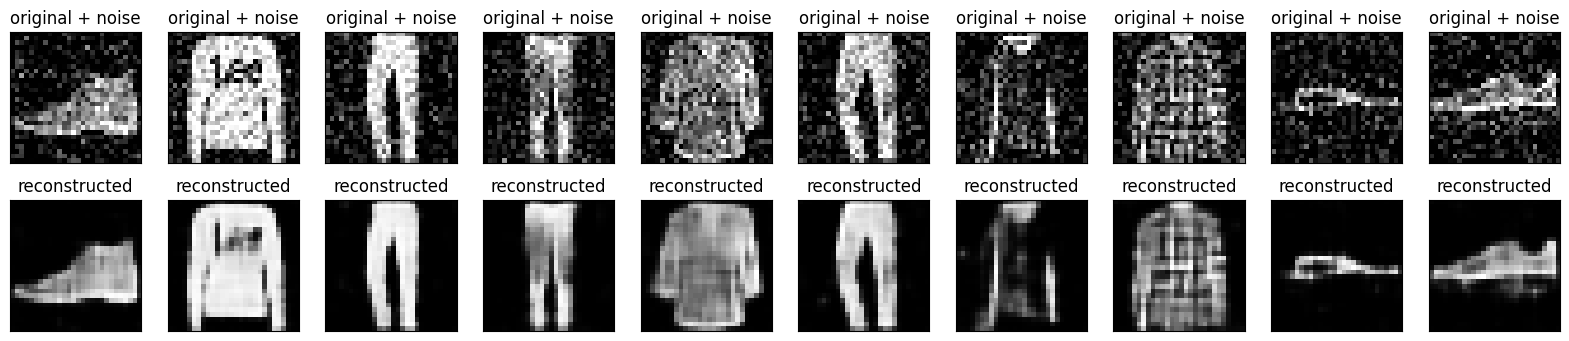

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## 第三个示例：异常检测

## 概述

在此示例中，您将训练自编码器来检测 [ECG5000 数据集](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)上的异常。此数据集包含 5,000 个[心电图](https://en.wikipedia.org/wiki/Electrocardiography)，每个心电图拥有 140 个数据点。您将使用简化版的数据集，其中每个样本都被标记为 `0`（对应于异常心律）或 `1`（对应于正常心律）。您需要关注如何识别异常心律。

注：这是一个有标签的数据集，因此您可以将其表述为一个监督学习问题。此示例的目标是说明可应用于没有可用标签的大型数据集的异常检测概念（例如，如果您有成千上万个正常心律，而只有少量异常心律）。

您将如何使用自编码器检测异常？回想一下，自编码器经过训练后可最大程度地减少重构误差。您将只基于正常心律训练自编码器，随后使用它来重构所有数据。我们的假设是，异常心律存在更高的重构误差。随后，如果重构误差超过固定阈值，则将心律分类为异常。

### 加载心电图数据

您将使用的数据集基于 [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) 中的数据集。


In [20]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

0         1         2         3         4         5         6    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.257740  0.228077  0.123431  0.925286  0.193137  1.0  
1  0.555784  0.476333  0.773820  1.119621 -1.436250  1.0  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797  1.0  
3  0.952074  0.990133  1.086798  1.403011 -0.383564  1.0  
4  1.277392  0.960304  0.971020  1.614392  1.421456  1.0  

[5 rows x 141 columns]

In [21]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

将数据归一化为 `[0,1]`。


In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

您将仅使用正常心律训练自编码器，在此数据集中，正常心律被标记为 `1`。将正常心律与异常心律分开。

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

绘制正常的心电图。 

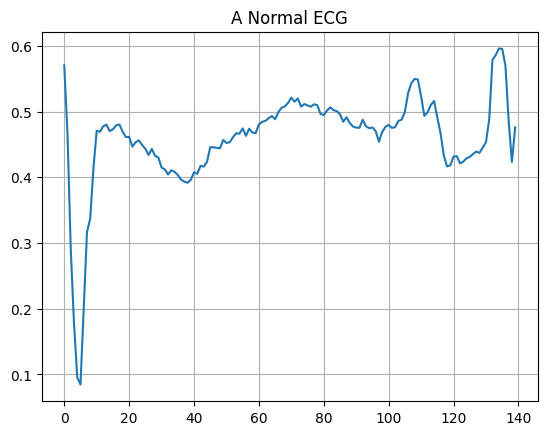

In [24]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

绘制异常的心电图。

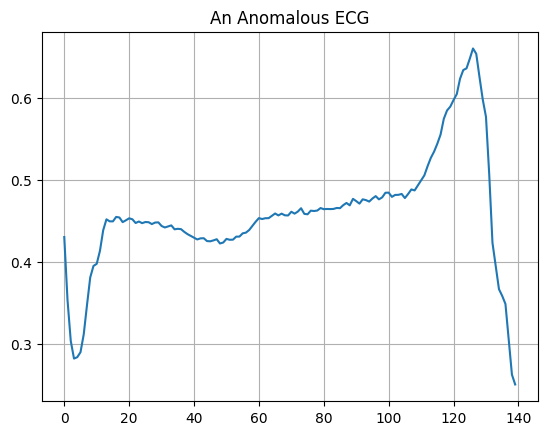

In [25]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### 构建模型

In [26]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

请注意，自编码器仅使用正常的心电图进行训练，但使用完整的测试集进行评估。

In [28]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20


1/5 [=====>........................] - ETA: 8s - loss: 0.0582

5/5 [==============================] - 2s 47ms/step - loss: 0.0575 - val_loss: 0.0530


Epoch 2/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0559

5/5 [==============================] - 0s 16ms/step - loss: 0.0548 - val_loss: 0.0510


Epoch 3/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0525

5/5 [==============================] - 0s 15ms/step - loss: 0.0509 - val_loss: 0.0492


Epoch 4/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0483

5/5 [==============================] - 0s 15ms/step - loss: 0.0464 - val_loss: 0.0469


Epoch 5/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0432

5/5 [==============================] - 0s 15ms/step - loss: 0.0416 - val_loss: 0.0444


Epoch 6/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0389

5/5 [==============================] - 0s 15ms/step - loss: 0.0373 - val_loss: 0.0420


Epoch 7/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0346

5/5 [==============================] - 0s 15ms/step - loss: 0.0337 - val_loss: 0.0406


Epoch 8/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0312

5/5 [==============================] - 0s 15ms/step - loss: 0.0310 - val_loss: 0.0396


Epoch 9/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0306

5/5 [==============================] - 0s 15ms/step - loss: 0.0291 - val_loss: 0.0389


Epoch 10/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0280

5/5 [==============================] - 0s 16ms/step - loss: 0.0277 - val_loss: 0.0381


Epoch 11/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0268

5/5 [==============================] - 0s 16ms/step - loss: 0.0265 - val_loss: 0.0373


Epoch 12/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0260

5/5 [==============================] - 0s 15ms/step - loss: 0.0255 - val_loss: 0.0365


Epoch 13/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0247

5/5 [==============================] - 0s 16ms/step - loss: 0.0247 - val_loss: 0.0358


Epoch 14/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0245

5/5 [==============================] - 0s 15ms/step - loss: 0.0239 - val_loss: 0.0350


Epoch 15/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0244

5/5 [==============================] - 0s 15ms/step - loss: 0.0233 - val_loss: 0.0349


Epoch 16/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0231

5/5 [==============================] - 0s 15ms/step - loss: 0.0227 - val_loss: 0.0342


Epoch 17/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0220

5/5 [==============================] - 0s 15ms/step - loss: 0.0221 - val_loss: 0.0340


Epoch 18/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0211

5/5 [==============================] - 0s 15ms/step - loss: 0.0217 - val_loss: 0.0338


Epoch 19/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0216

5/5 [==============================] - 0s 15ms/step - loss: 0.0212 - val_loss: 0.0335


Epoch 20/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0207

5/5 [==============================] - 0s 15ms/step - loss: 0.0209 - val_loss: 0.0334


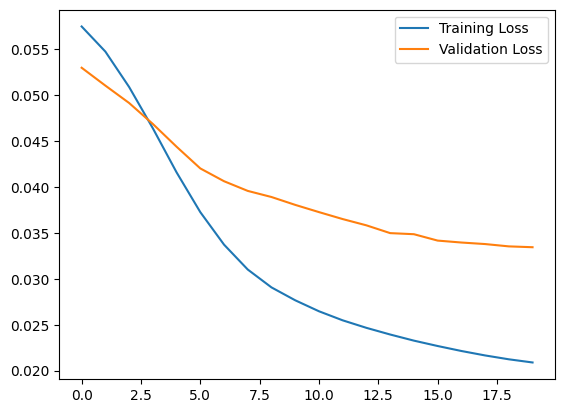

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

如果重构误差比正常训练样本大一个标准差，您可以快速地将心电图归类为异常。首先，我们绘制训练集中的一个正常心电图，随后绘制自编码器对其进行编码和解码后的重构以及重构误差。

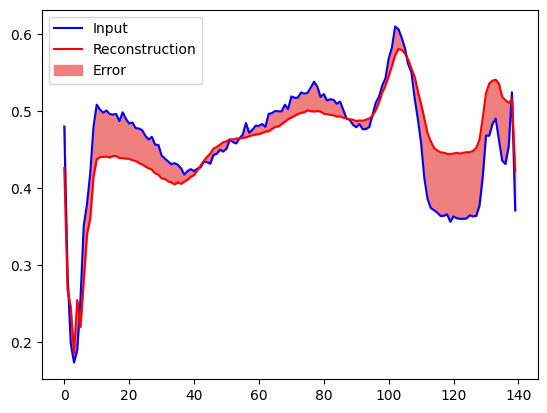

In [30]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

创建一个类似的绘图，这次是一个异常的测试样本。

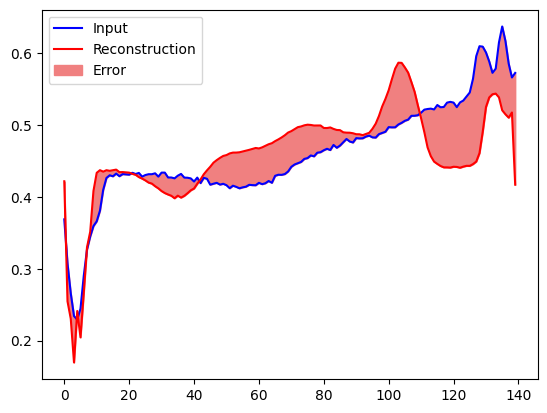

In [31]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### 检测异常

通过计算重构损失是否大于固定阈值来检测异常。在本教程中，您将计算训练集中正常样本的平均误差，如果重构误差比训练集大一个标准差，则将未来的样本分类为异常。


根据训练集中的正常心电图绘制重构误差：

 1/74 [..............................] - ETA: 8s

37/74 [==============>...............] - ETA: 0s

74/74 [==============================] - 0s 1ms/step


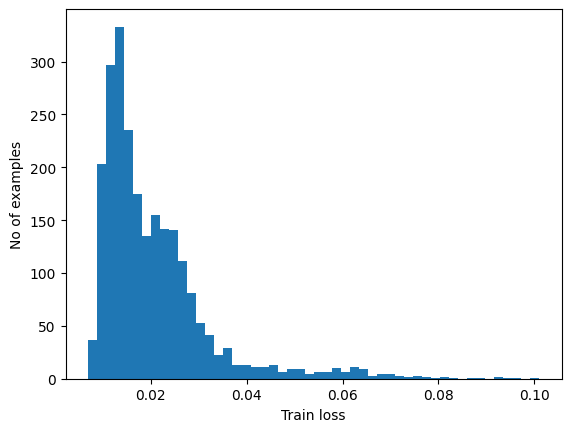

In [32]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

选择一个比平均值高一个标准差的阈值。

In [33]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032788377


注：还有其他可用来选择阈值的策略，高于该阈值时，应将测试样本分类为异常，正确的方式将取决于您的数据集。您可以通过本教程末尾的链接了解更多信息。 

如果检查测试集中异常样本的重构误差，您会注意到大多数异常样本的重构误差都比阈值大。通过更改阈值，您可以调整分类器的[精确率](https://developers.google.com/machine-learning/glossary#precision)和[召回率](https://developers.google.com/machine-learning/glossary#recall)。 

 1/14 [=>............................] - ETA: 0s

14/14 [==============================] - 0s 1ms/step


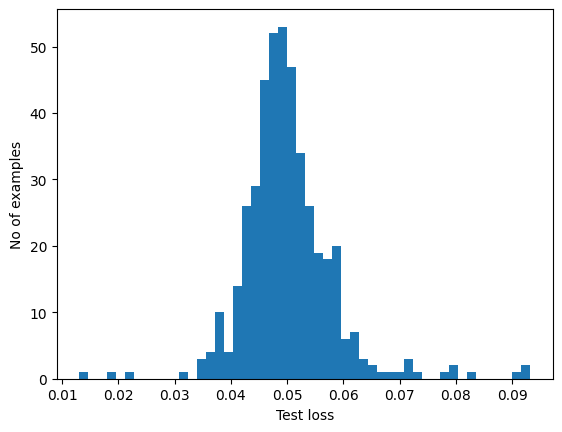

In [34]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

如果重构误差大于阈值，则将心电图分类为异常。

In [35]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935


Recall = 0.9053571428571429


## 后续步骤

要详细了解如何使用自编码器检测异常，请查看 Victor Dibia 使用 TensorFlow.js 构建的出色[交互式示例](https://anomagram.fastforwardlabs.com/#/)。对于真实用例，您可以了解 [Airbus 如何使用 TensorFlow 检测 ISS 遥测数据中的异常](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html)。要详细了解基础知识，请考虑阅读 François Chollet 撰写的这篇[博文](https://blog.keras.io/building-autoencoders-in-keras.html)。有关更多详细信息，请查看 Ian Goodfellow、Yoshua Bengio 和 Aaron Courville 撰写的[《深度学习》](https://www.deeplearningbook.org/)一书的第 14 章。
